# Pós-Graduação Strictu Sensu em Ciências da Computação
----
**Universidade Federal de Pernambuco**

**Disciplina**: Aprendizado de Máquina

**Discentes**: Jose Adeljan Marinho da Silva

Matheus Hopper Jansen Costa

Heitor Leite Ramos

Jefferson Medeiros Norberto

Karoline Juliana Costa da Silva

**Docente**: Leandro Maciel Almeida

----

# Sumário:

0. [Importação das bibliotecas](#importação-das-bibliotecas-utilizadas)
1. [Introdução](#introdução)
2. [Análise Exploratória dos Dados](#análise-exploratória-dos-dados)
3. [Preparação dos dados](#preparação-dos-dados)
4. [Modelagem e Otimização](#modelagem-e-otimização)
5. [Avaliação dos Modelos](#avaliação-dos-modelos)
6. [Análise de Custo-Benefício](#análise-de-custo-benefício)
7. [Teste de Estresse dos Modelos](#teste-de-estresse-dos-modelos)
8. [Discussão sobre Limitações e Futuras Melhorias](#discussão-sobre-limitações-e-futuras-melhorias)
9. [Resumo Executivo](#resumo-executivo)
10. [Comparação com Benchmarks conhecidos](#comparação-com-benchmarks-conhecidos)
11. [Desenvolvimento detalhado do projeto](#desenvolvimento-detalhado-do-projeto)
12. [Conclusão](#conclusão)
13. [Referências](#referências)


# Importação das bibliotecas utilizadas

In [98]:
!pip install openml

In [185]:
import openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import ADASYN
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

# Validação e métricas
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, make_scorer, f1_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

# Bibliotecas adicionais
import optuna
from optuna.integration.mlflow import MLflowCallback
import mlflow
import mlflow.sklearn
import time
import sys

warnings.filterwarnings('ignore')

# Introdução

O diabetes mellitus é considerado uma epidemia global, representando um desafio significativo para os sistemas de saúde. Dados da Organização Mundial da Saúde indicam que, em 2014, mais de 422 milhões de pessoas viviam com diabetes, e em 2016, 1,6 milhão de mortes foram atribuídas diretamente à doença (World Health Organization (WHO) (2020)). No Brasil, o cenário também é preocupante: a Pesquisa Nacional de Saúde de 2019 reportou uma prevalência de 7,7% entre adultos acima de 18 anos (PNS (2019)), o que equivale a cerca de 12,3 milhões de pessoas. Este impacto, tanto clínico quanto social, reforça a necessidade de estratégias baseadas em dados para otimizar o cuidado e reduzir os custos associados ao manejo do diabetes.

O presente estudo utiliza o dataset "Diabetes130US", que reúne informações clínicas e hospitalares de pacientes diabéticos atendidos em 130 hospitais nos Estados Unidos ao longo de uma década (1999–2008). Com mais de 40 atributos, o conjunto de dados possibilita a análise de fatores clínicos, demográficos e resultados hospitalares, oferecendo insights valiosos para a identificação de padrões de tratamento e fatores que impactam a saúde dos pacientes.

Entre os desafios investigados, destaca-se a previsão de readmissões hospitalares. A antecipação de quais pacientes têm maior probabilidade de serem readmitidos pode auxiliar na implementação de intervenções preventivas, na melhoria da qualidade do atendimento e na redução de custos com hospitalizações desnecessárias. Esse objetivo requer a aplicação de técnicas de aprendizado de máquina, que permitem transformar dados brutos em informações acionáveis.

O projeto seguiu uma abordagem iterativa e cíclica, alinhada ao ciclo de vida de projetos de ciência de dados. Iniciou-se com o entendimento do problema e dos dados, etapa crucial para garantir que as análises estejam direcionadas às questões centrais do estudo (Fawcett and Provost (2013), Jiawei Han and Pei (2012)). O dataset foi minuciosamente explorado para compreender seus atributos, identificar lacunas, eliminar redundâncias e realizar transformações necessárias. Esse cuidado na preparação garantiu maior qualidade para a modelagem e reduziu riscos de interpretações equivocadas.

Com foco na previsão de readmissões, o relatório documenta o processo de seleção, treinamento e avaliação de diferentes algoritmos de aprendizado de máquina. Modelos como K-Nearest Neighbors (K-NN), Support Vector Machine (SVM), Random Forest, XGBoost, entre outros, foram otimizados e comparados usando validação cruzada estratificada, técnicas de balanceamento de dados e análise estatística.

----

# Análise Exploratória dos Dados

In [171]:
dataset = openml.datasets.get_dataset(45069)

# Carregar o dataset
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

# Mostrar as primeiras linhas do DataFrame
df = pd.concat([X, y], axis=1)
df_bruto = df.copy(deep=True)

In [172]:
# Verificar a quantidade e percentual de valores ausentes em cada coluna
valores_ausentes = df.isnull().sum()
percentual_ausentes = (df.isnull().sum() / len(df)) * 100

# Criar um dataframe com as informações
missing_values = pd.DataFrame({
    'Total de Valores Ausentes': valores_ausentes,
    'Percentual (%)': percentual_ausentes
})

# Ordenar pelo percentual de valores ausentes
missing_values = missing_values[missing_values['Total de Valores Ausentes'] > 0]
missing_values.sort_values('Percentual (%)', ascending=False, inplace=True)

print("Valores ausentes por coluna:")
print(missing_values)

Valores ausentes por coluna:
                   Total de Valores Ausentes  Percentual (%)
weight                                 98569       96.858479
medical_specialty                      49949       49.082208
payer_code                             40256       39.557416
race                                    2273        2.233555
diag_3                                  1423        1.398306
diag_2                                   358        0.351787
diag_1                                    21        0.020636


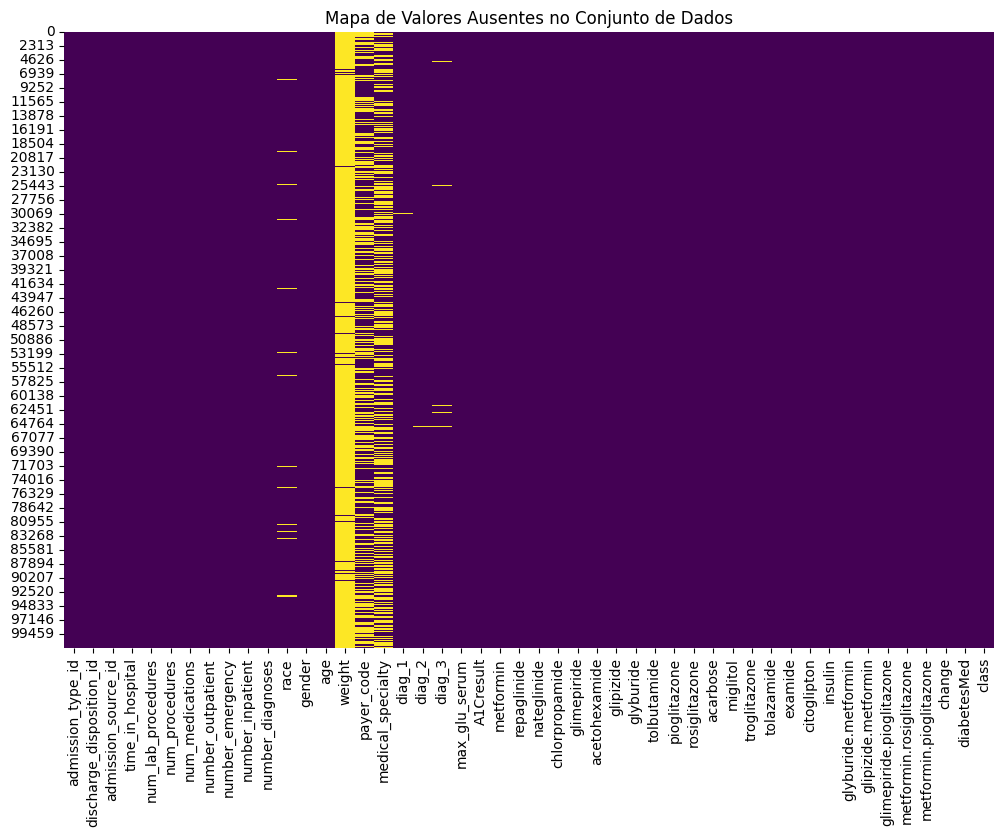

In [173]:
# Visualizar o padrão de valores ausentes
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de Valores Ausentes no Conjunto de Dados')
plt.show()

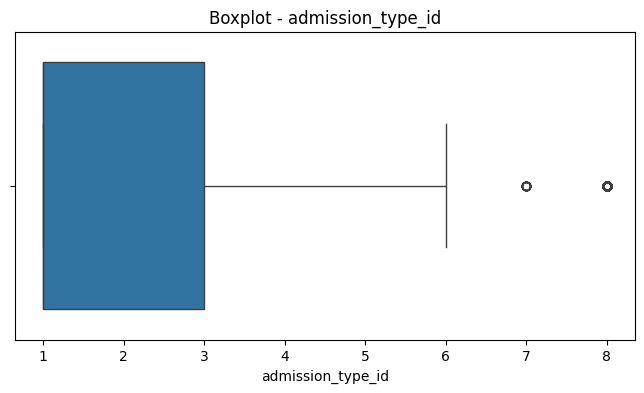

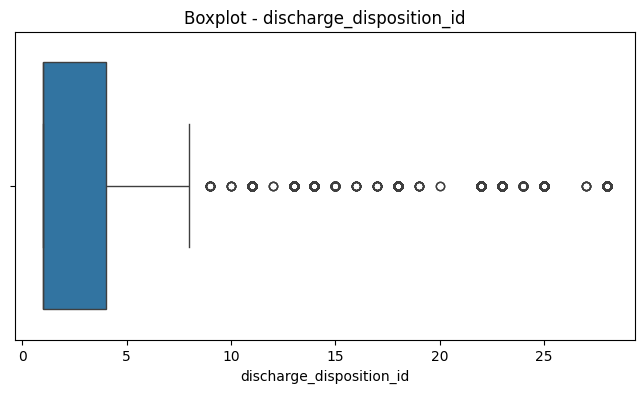

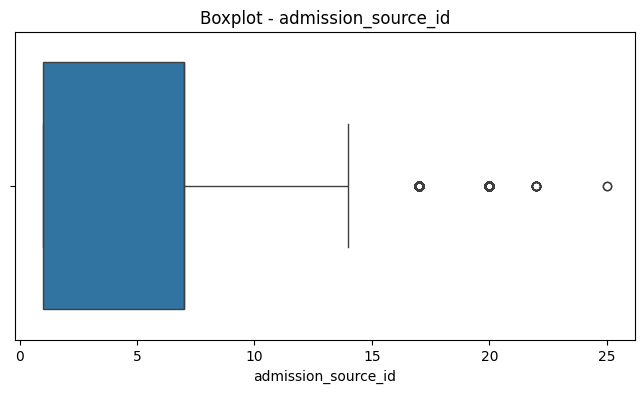

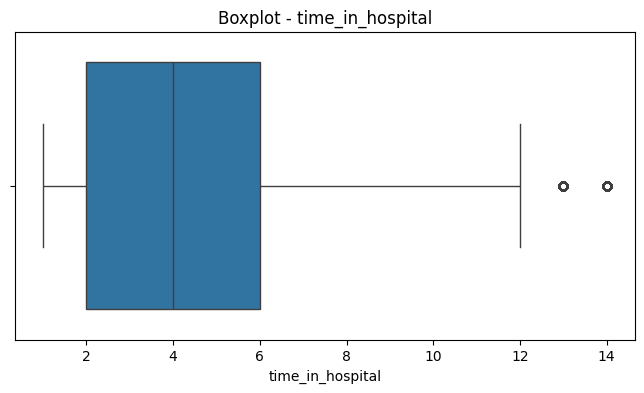

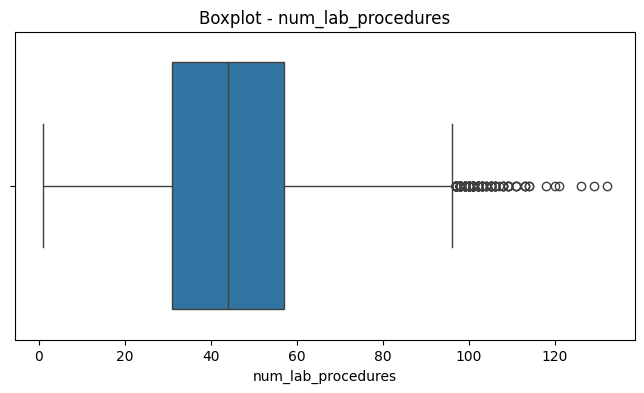

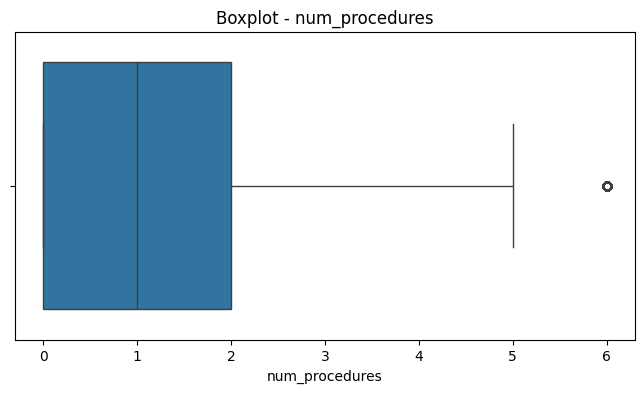

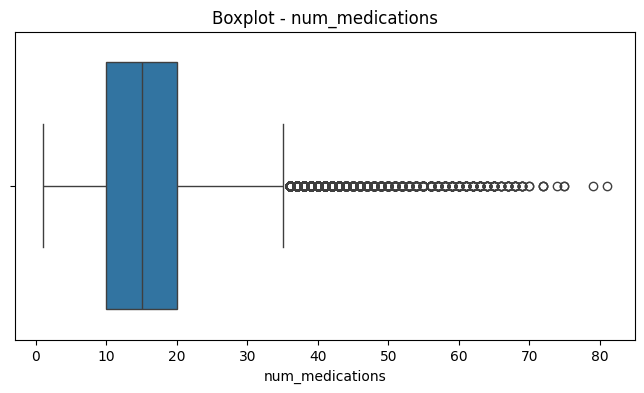

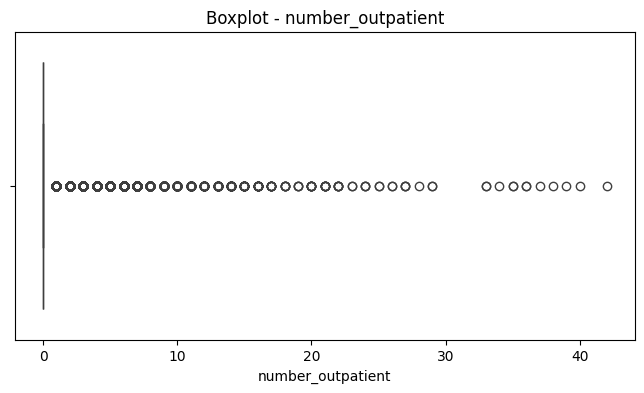

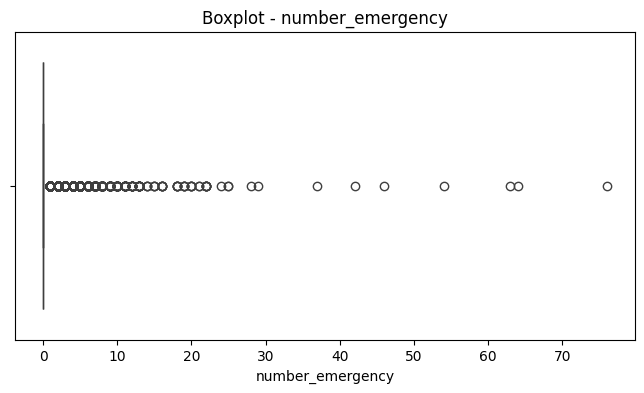

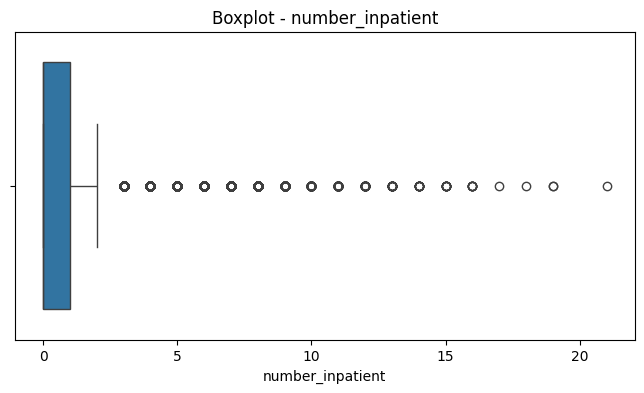

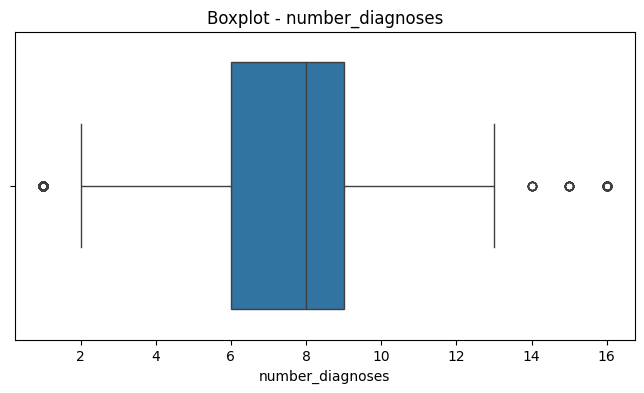

In [174]:
# Identificação de outliers
# Selecionar colunas numéricas
colunas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

# Boxplots para cada variável numérica
for col in colunas_numericas:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot - {col}')
    plt.xlabel(col)
    plt.show()

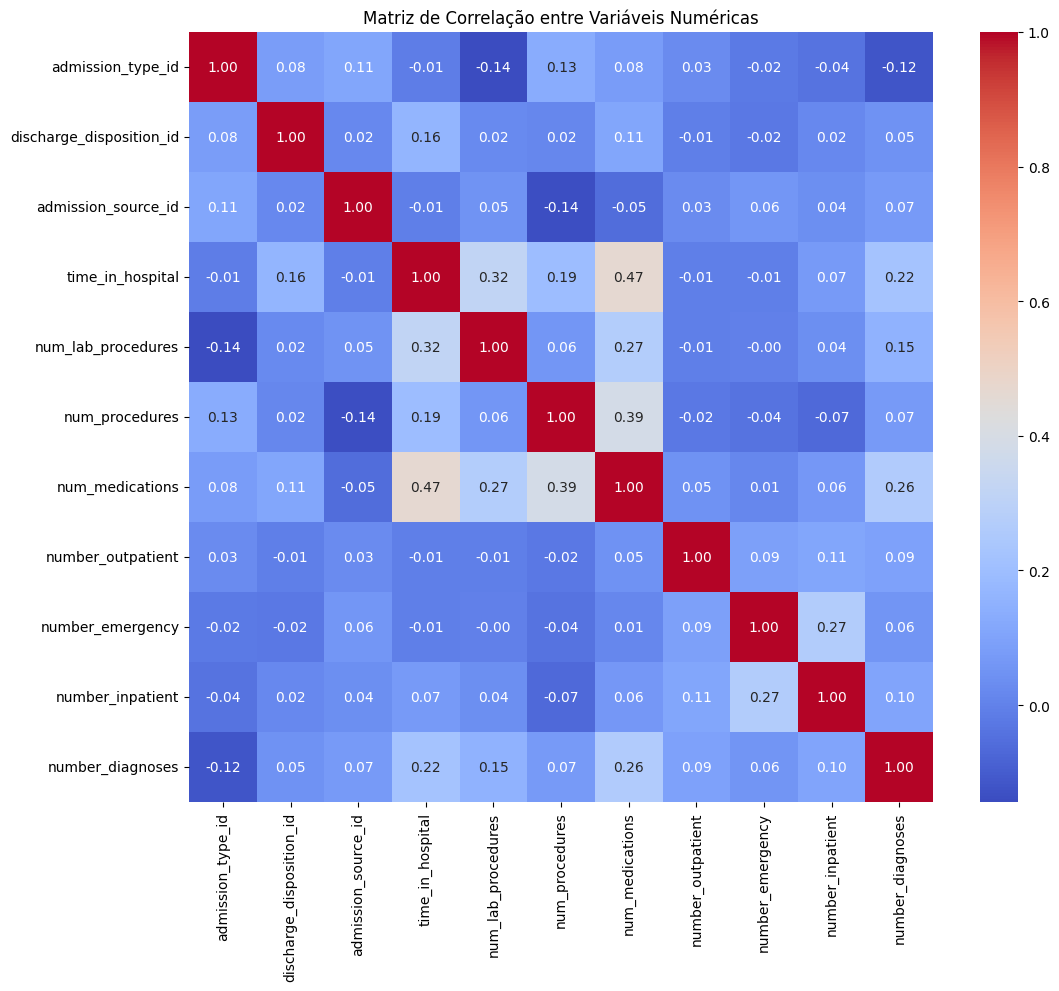

In [175]:
# Matriz de correlação
correlacao = df[colunas_numericas].corr()

# Heatmap da matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()

In [176]:
# Análise de variáveis categóricas (frequências, modos, etc.)
# Selecionar colunas categóricas
colunas_categoricas = df.select_dtypes(include=['object']).columns.tolist()

# Remover colunas que não são relevantes para a análise
colunas_categoricas = [col for col in colunas_categoricas if col not in ['encounter_id', 'patient_nbr']]

# Análise de frequências e modos
for col in colunas_categoricas:
    print(f"\nAnálise da variável categórica: {col}")
    print(f"Total de categorias: {df[col].nunique()}")
    print("Frequências das principais categorias:")
    print(df[col].value_counts().head())
    print(f"Modo: {df[col].mode()[0]}")


Análise da variável categórica: class
Total de categorias: 3
Frequências das principais categorias:
class
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64
Modo: NO


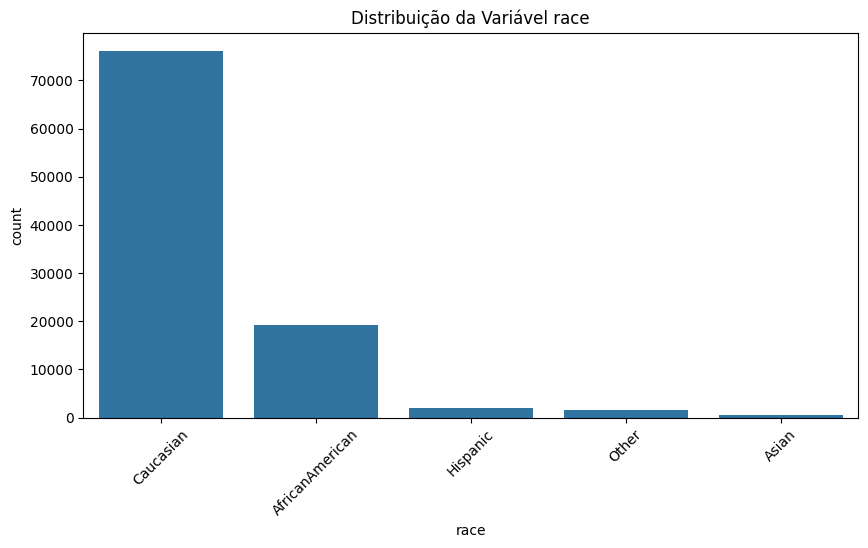

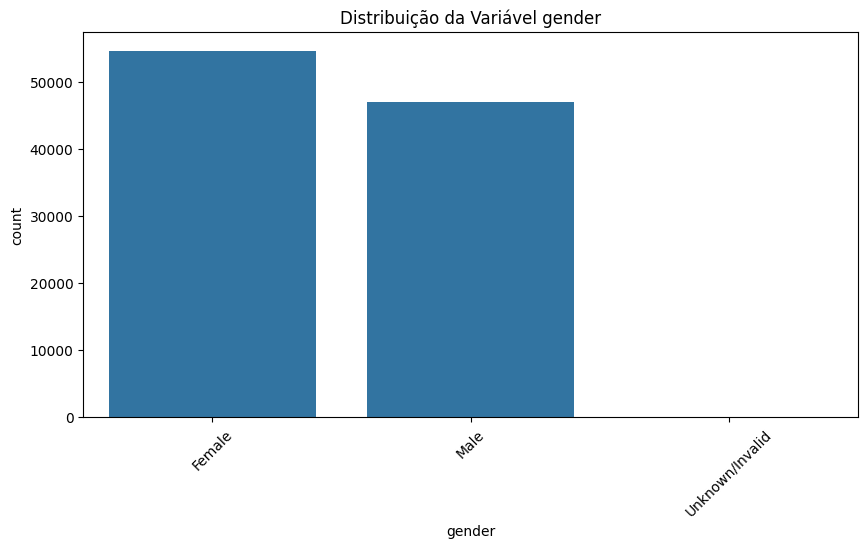

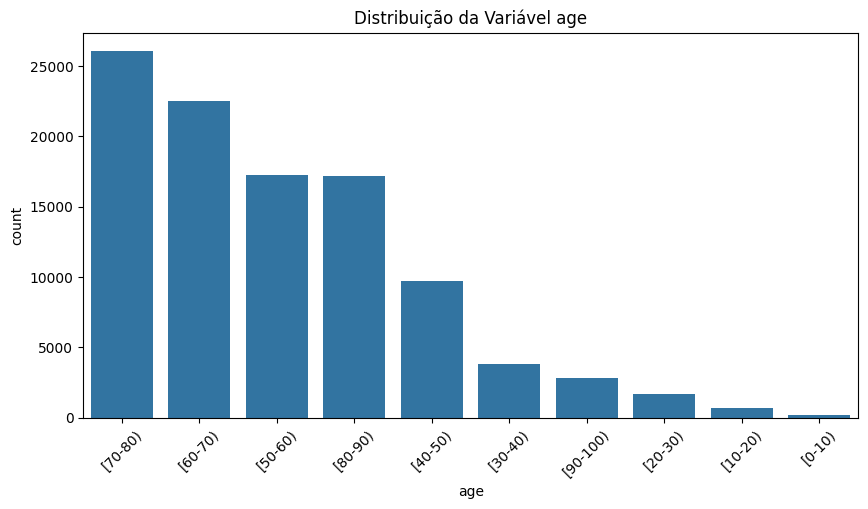

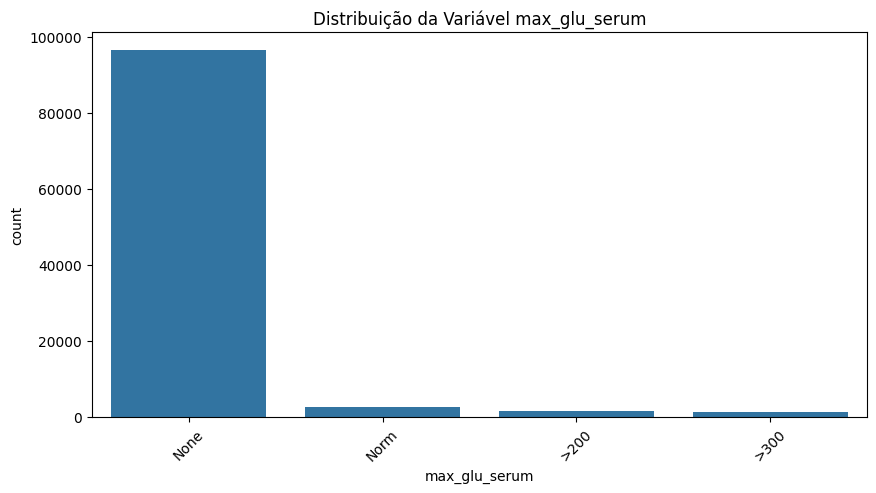

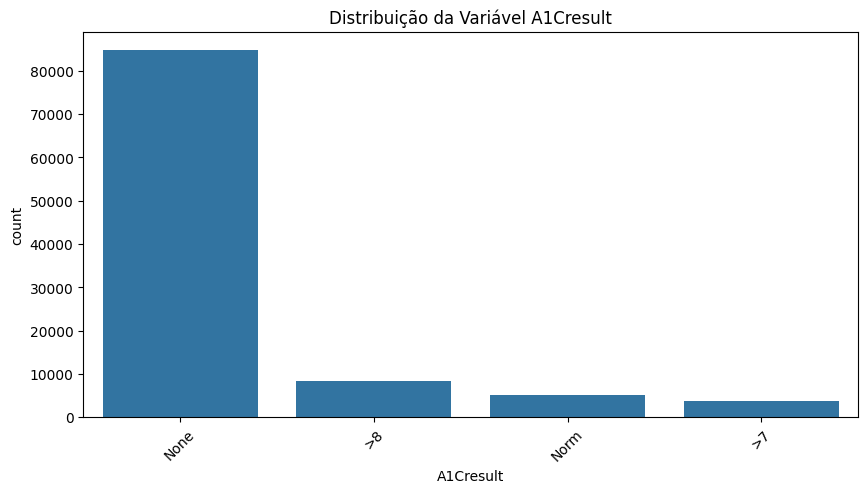

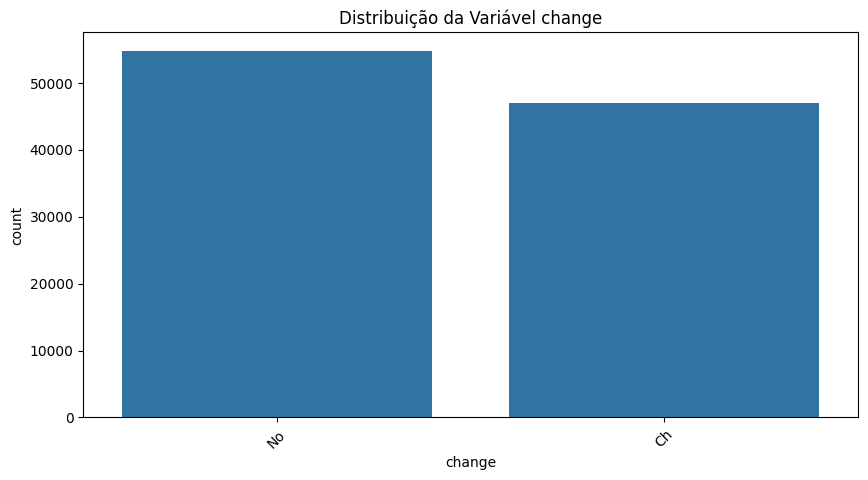

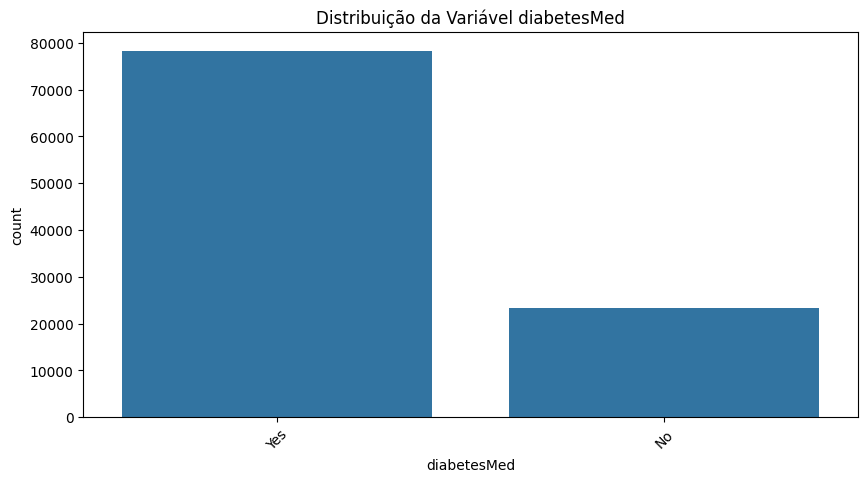

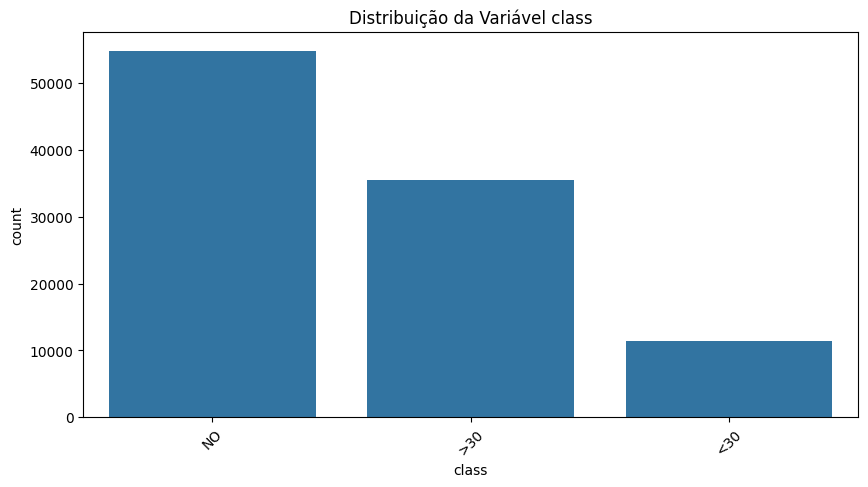

In [177]:
# Gráficos de barras para variáveis categóricas selecionadas
variaveis_para_plotar = ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'class']

for col in variaveis_para_plotar:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribuição da Variável {col}')
    plt.xticks(rotation=45)
    plt.show()

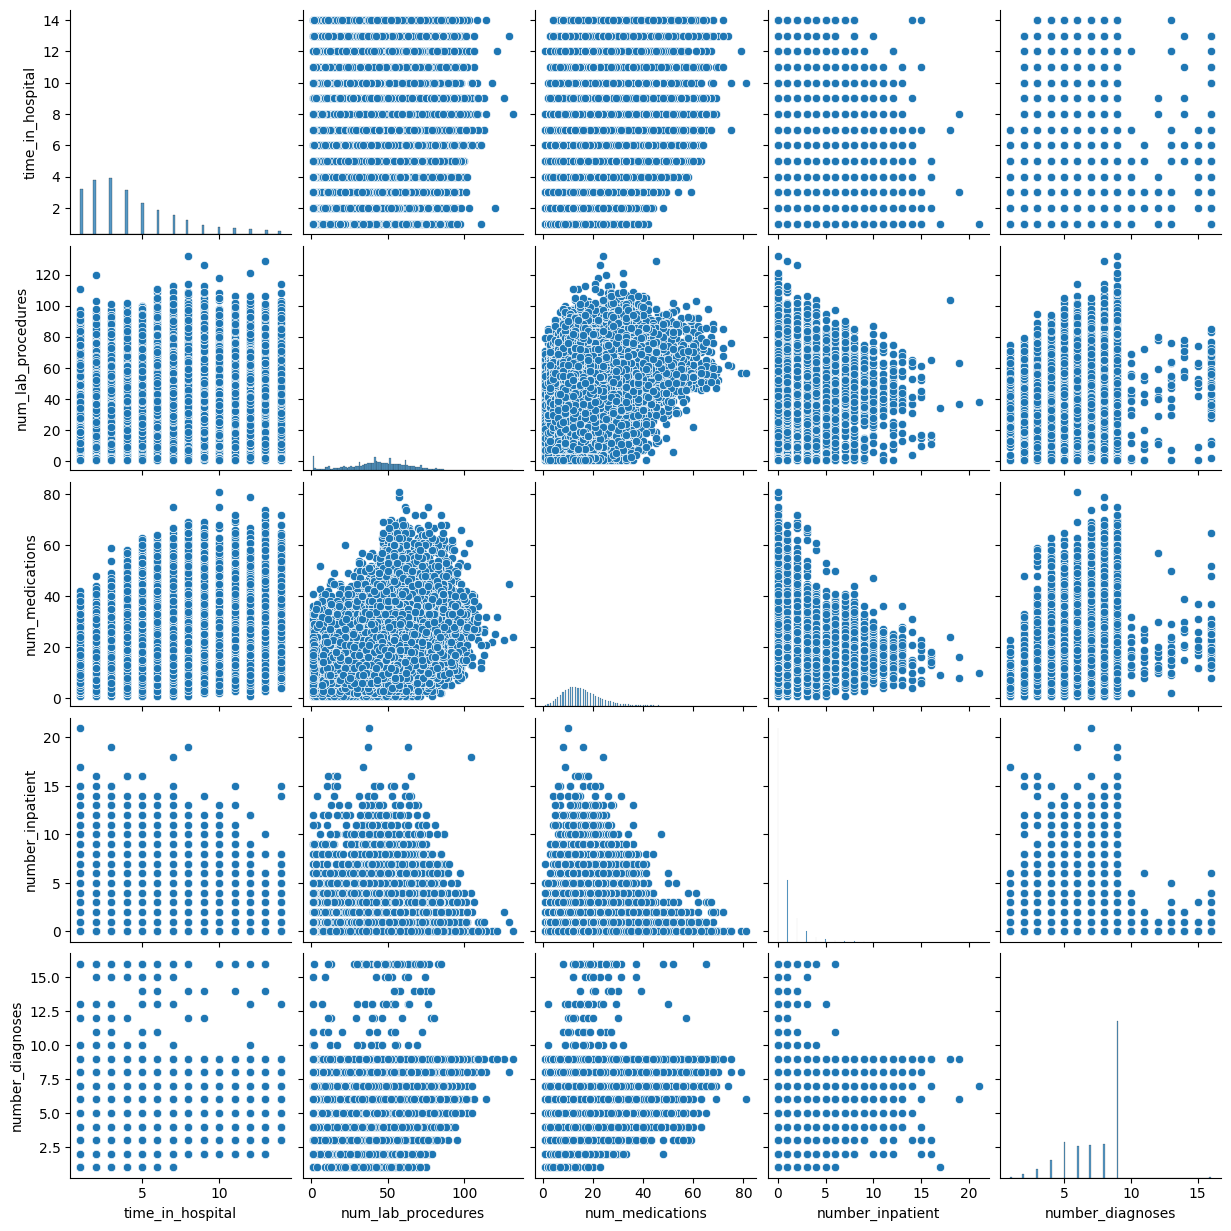

In [178]:
# Visualizações adicionais
# Pair Plot das Variáveis Numéricas
# Subconjunto de variáveis numéricas
subconjunto_numerico = ['time_in_hospital', 'num_lab_procedures', 'num_medications', 'number_inpatient', 'number_diagnoses']

sns.pairplot(df[subconjunto_numerico])
plt.show()

In [180]:
# Análise das Relações entre Variáveis Categóricas e a target
variavel_alvo = 'class'

for col in colunas_categoricas:
    if col != variavel_alvo:
        plt.figure(figsize=(10, 5))
        sns.countplot(x=col, hue=variavel_alvo, data=df, order=df[col].value_counts().index)
        plt.title(f'Distribuição de {col} por {variavel_alvo}')
        plt.xticks(rotation=45)
        plt.legend(title=variavel_alvo)
        plt.show()

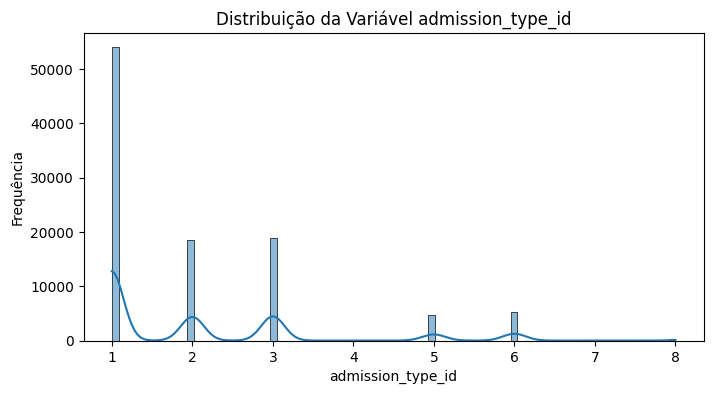

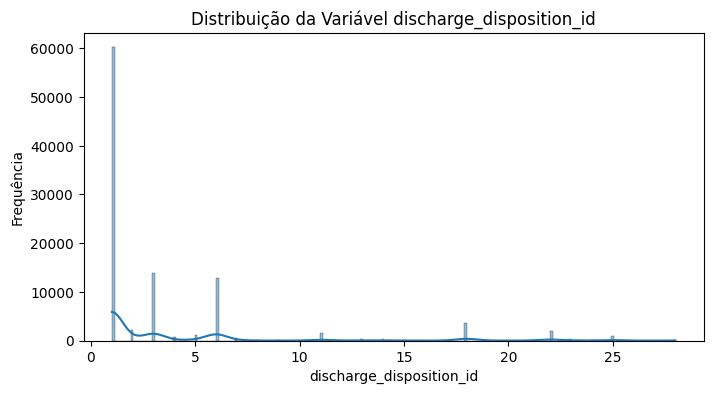

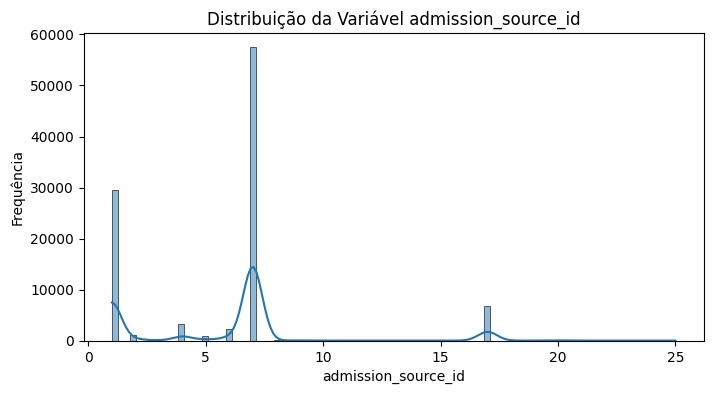

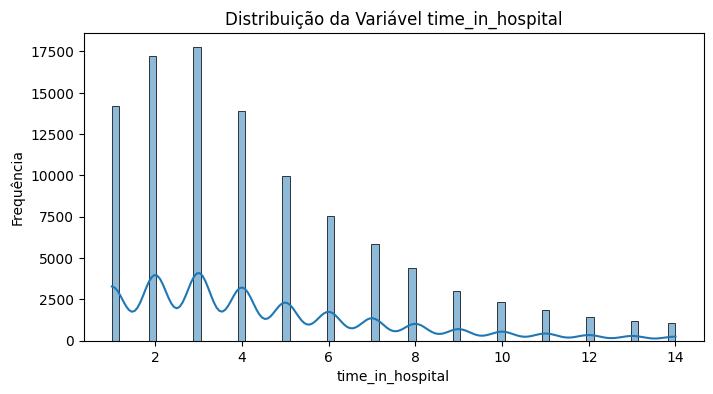

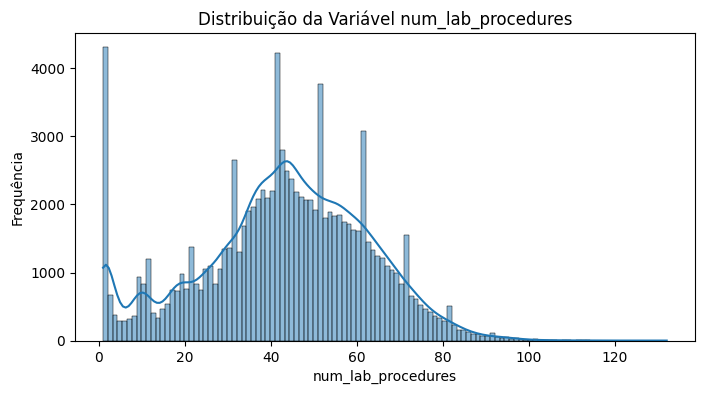

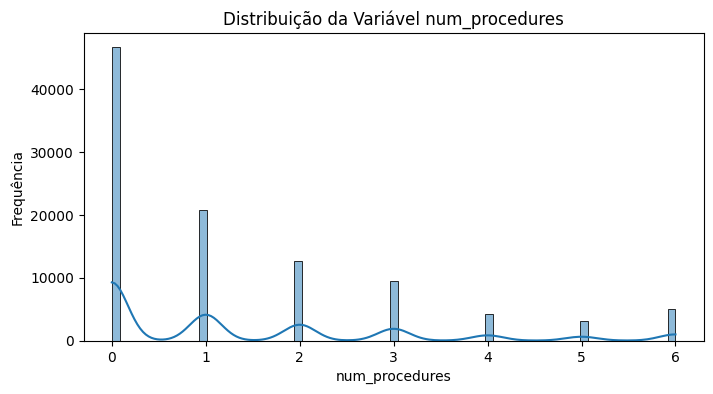

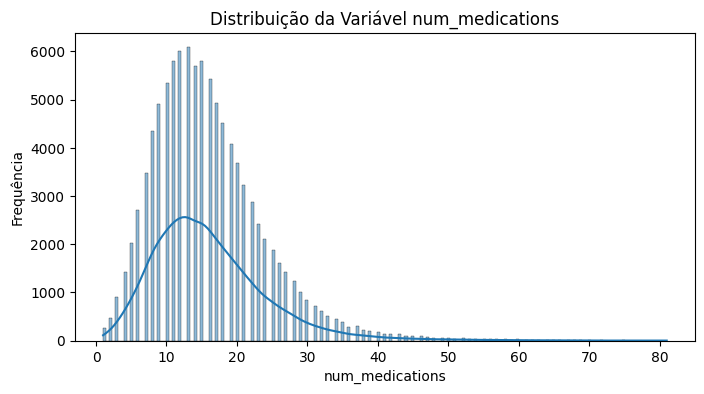

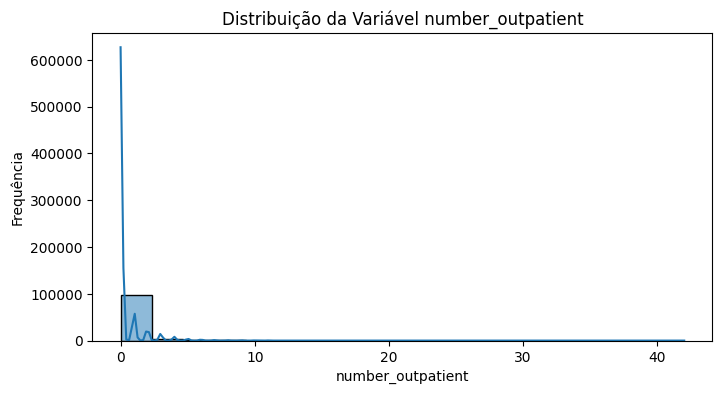

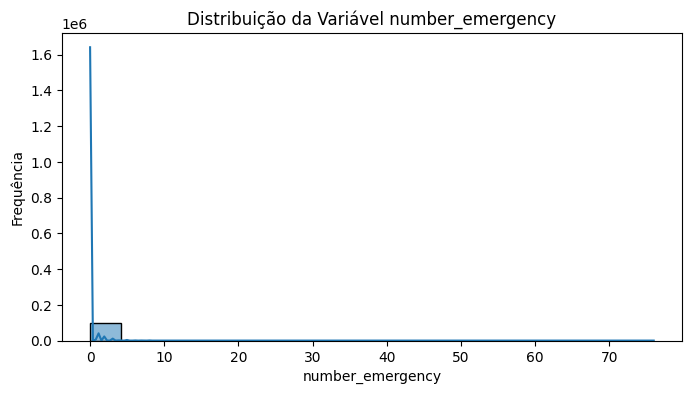

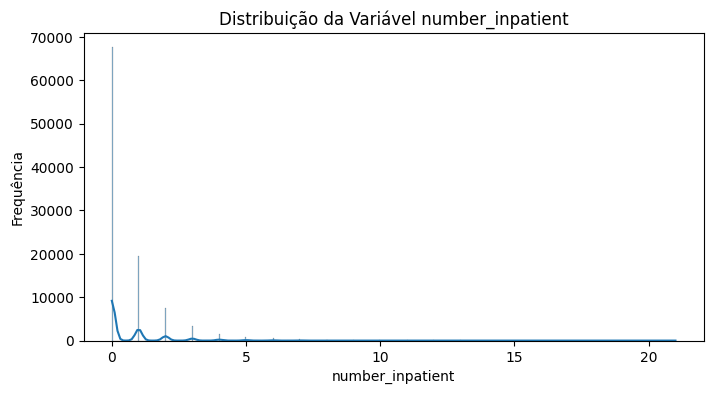

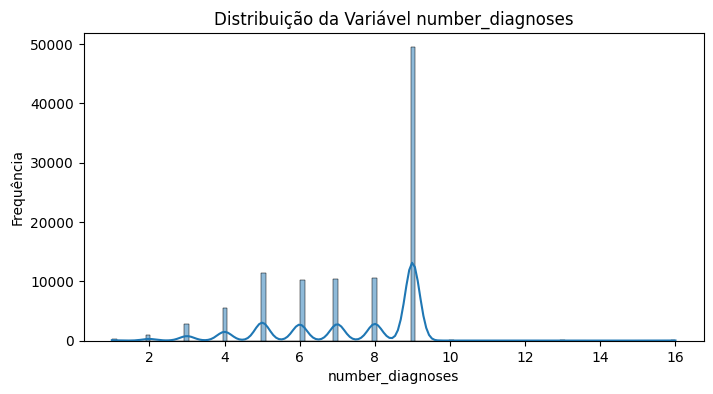

In [181]:
# Análise de Distribuição das Variáveis Numéricas
# Histogramas e KDE plots para variáveis numéricas
for col in colunas_numericas:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuição da Variável {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.show()

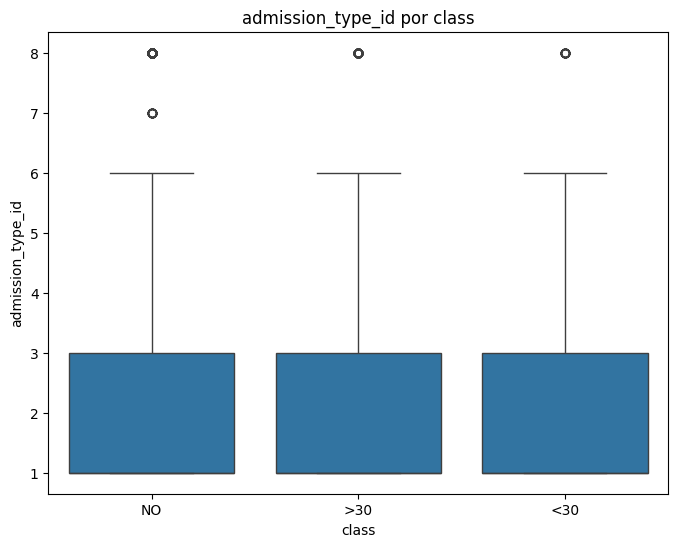

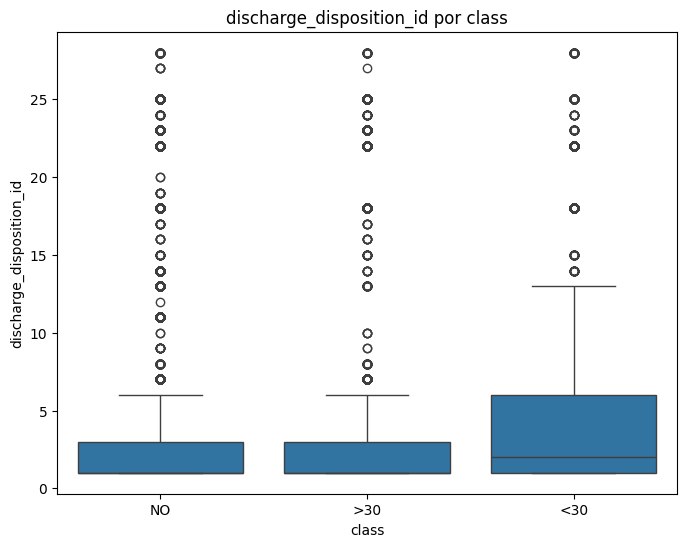

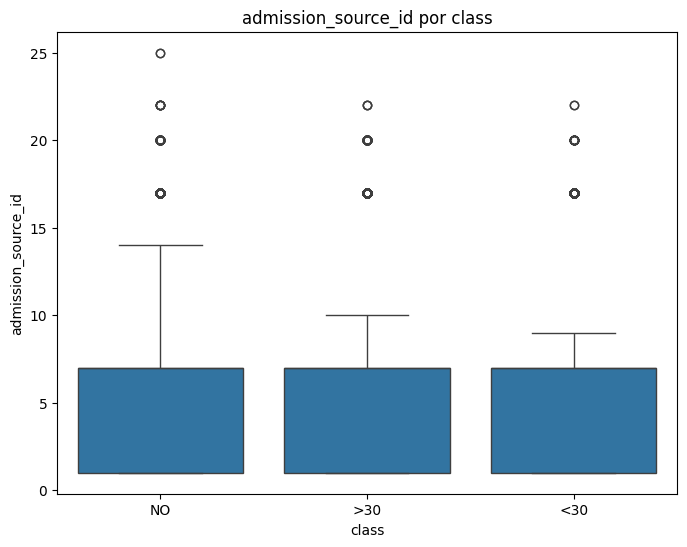

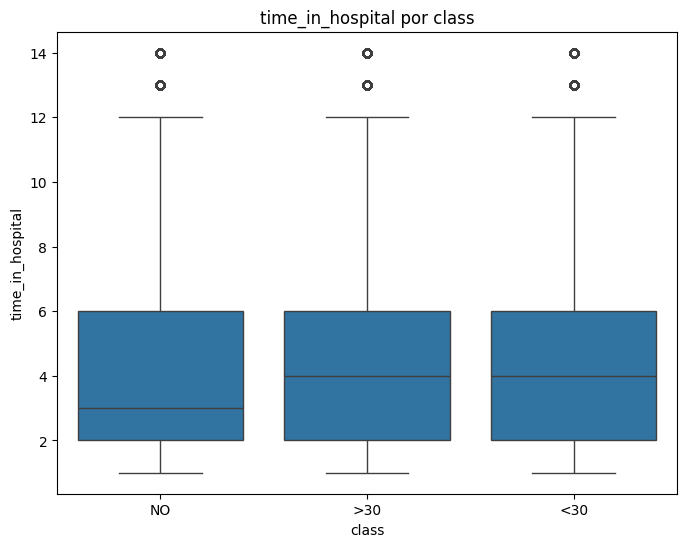

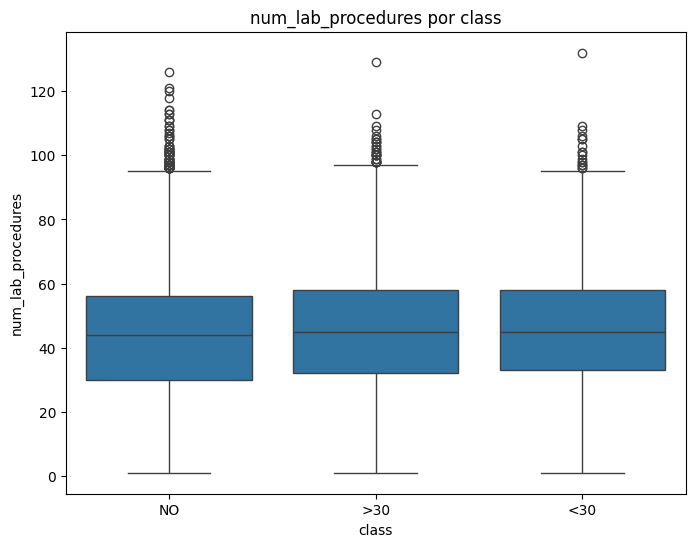

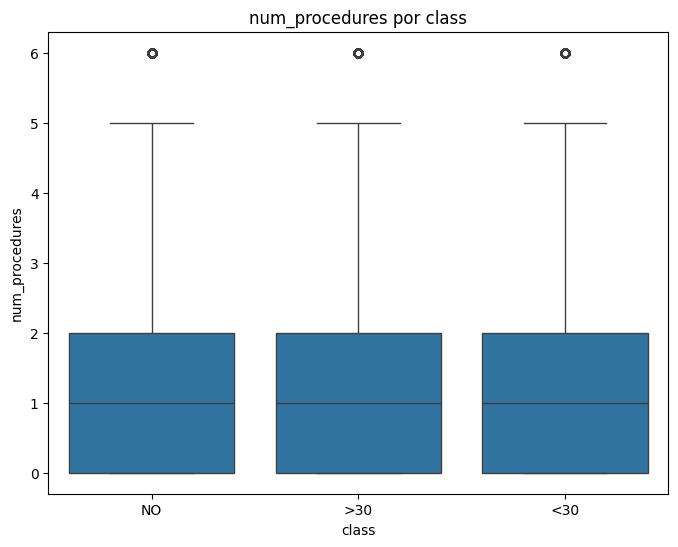

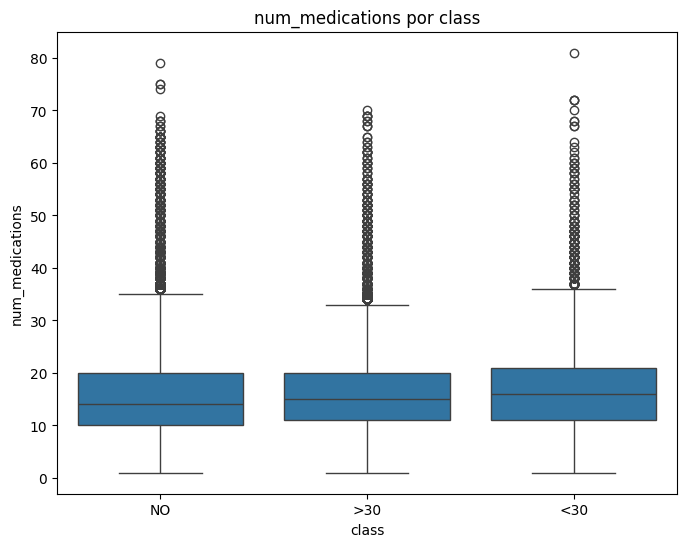

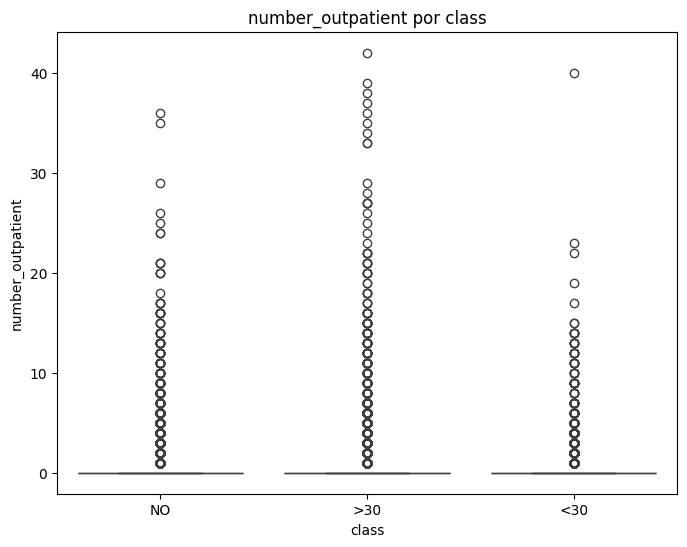

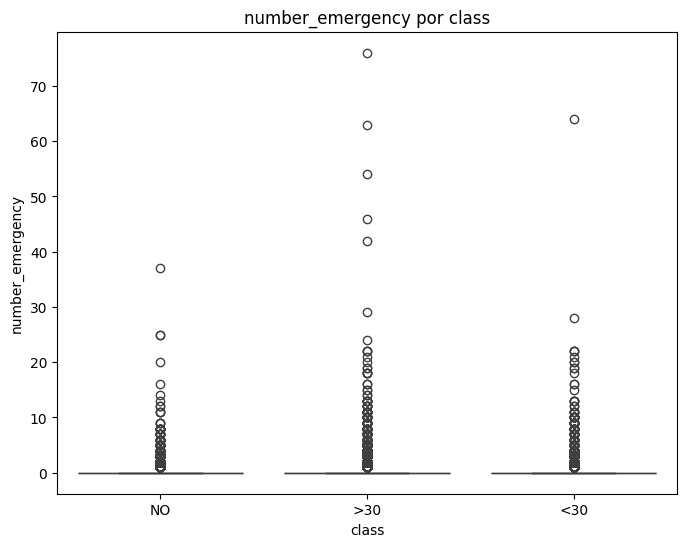

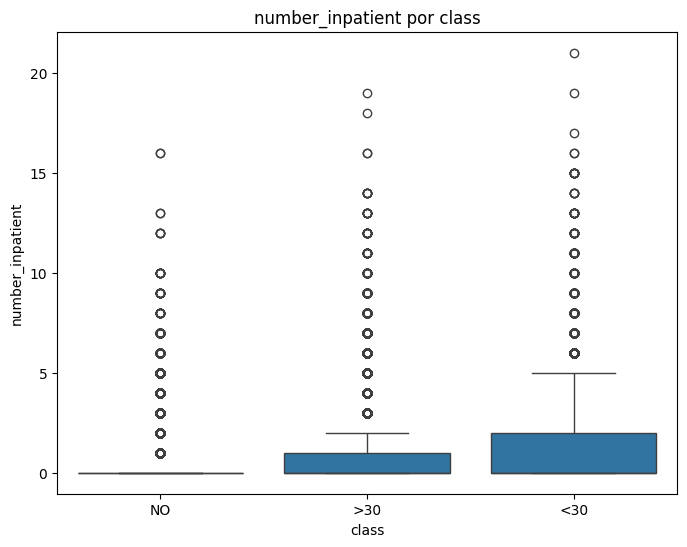

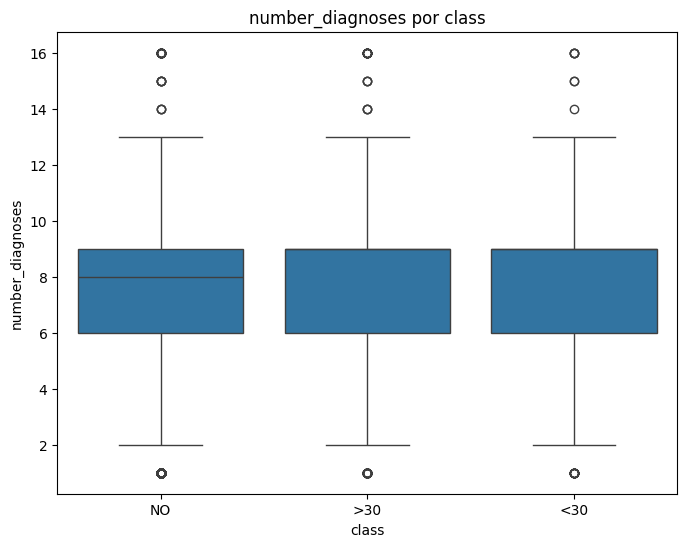

In [182]:
# Análise de Relação entre Variáveis Numéricas e Categóricas
# Boxplots para visualizar a distribuição de variáveis numéricas por categorias da variável alvo
for col in colunas_numericas:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=variavel_alvo, y=col, data=df)
    plt.title(f'{col} por {variavel_alvo}')
    plt.show()

In [183]:
# Análise de Variáveis com Muitos Valores Distintos
# Listar as variáveis categóricas com mais de 50 categorias
variaveis_muitas_categorias = [col for col in colunas_categoricas if df[col].nunique() > 50]

print("Variáveis categóricas com muitos valores distintos:")
for col in variaveis_muitas_categorias:
    print(f"{col}: {df[col].nunique()} categorias")

Variáveis categóricas com muitos valores distintos:


In [186]:
# Análise de Multicolinearidade
# Variance Inflation Factor (VIF) para avaliar a multicolinearidade entre as variáveis numéricas

# Calcular o VIF para cada variável numérica
vif_data = pd.DataFrame()
vif_data["Variável"] = colunas_numericas
vif_data["VIF"] = [variance_inflation_factor(df[colunas_numericas].fillna(0).values, i)
                   for i in range(len(colunas_numericas))]

print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
                    Variável       VIF
0          admission_type_id  0.001125
1   discharge_disposition_id  0.000010
2        admission_source_id  0.000022
3           time_in_hospital  0.000104
4         num_lab_procedures  0.000002
5             num_procedures  0.000211
6            num_medications  0.000009
7          number_outpatient  0.001019
8           number_emergency  0.002282
9           number_inpatient  0.000961
10          number_diagnoses  0.000330


----

# Preparação dos dados

In [101]:
# Transformação do target em binário
df['class'] = [1 if each=='<30' else 0 for each in df['class']]

In [102]:
# Transformação das colunas categóricas em string
categorical_cols = df.select_dtypes(include='category').columns
df[categorical_cols] = df[categorical_cols].astype('object')

In [103]:
df["race"].fillna(df["race"].mode()[0], inplace = True)

In [104]:
data = df.loc[~df.discharge_disposition_id.isin([11,18,19,20,21,7,25,26])]

In [105]:
diag_list = ['diag_1','diag_2','diag_3']

for col in diag_list:
    df[col].fillna('NaN', inplace=True)

In [106]:
def transformFunc(value):
    value = re.sub("V[0-9]*", "0", value) # V
    value = re.sub("E[0-9]*", "0", value) # E
    value = re.sub('NaN', "-1", value) # Nan
    return value

def transformCategory(value):
    if value>=390 and value<=459 or value==785:
        category = 'Circulatory'
    elif value>=460 and value<=519 or value==786:
        category = 'Respiratory'
    elif value>=520 and value<=579 or value==787:
        category = 'Digestive'
    elif value==250:
        category = 'Diabetes'
    elif value>=800 and value<=999:
        category = 'Injury'
    elif value>=710 and value<=739:
        category = 'Musculoskeletal'
    elif value>=580 and value<=629 or value==788:
        category = 'Genitourinary'
    elif value>=140 and value<=239 :
        category = 'Neoplasms'
    elif value==-1:
        category = 'NAN'
    else :
        category = 'Other'

    return category

In [107]:
for col in diag_list:
    df[col] = df[col].apply(transformFunc)
    df[col] = df[col].astype(float)

In [108]:
for col in diag_list:
    df[col] = df[col].apply(transformCategory)

In [109]:
numerical_columns = df.select_dtypes(include=['uint8', 'int64']).columns.tolist()
numerical_columns.remove('class')

In [110]:
clf = LocalOutlierFactor(n_neighbors = 2 , contamination = 0.1)
clf.fit_predict(df[numerical_columns])

array([1, 1, 1, ..., 1, 1, 1])

In [111]:
df_scores = clf.negative_outlier_factor_
df_scores[0:30]

array([-1.11237244e+00, -1.00000000e+00, -1.05618622e+00, -1.00000000e+00,
       -9.64101615e-01, -9.76153125e-01, -1.20628580e+00, -1.00000000e+00,
       -9.54124145e-01, -1.00000000e+00, -1.35838165e+00, -1.06769362e+00,
       -9.73606798e-01, -9.65428645e-01, -1.18383741e+00, -1.16313671e+00,
       -1.21086536e+00, -5.00000000e+09, -1.41421356e+00, -1.13567449e+00,
       -1.00000000e+00, -1.17157288e+00, -1.28656609e+00, -1.22474487e+00,
       -1.10355339e+00, -1.31392974e+00, -1.02160050e+00, -1.19841474e+00,
       -1.10102051e+00, -1.17157288e+00])

In [112]:
np.sort(df_scores)[0:30]

array([-3.31662479e+10, -2.64575131e+10, -2.23606798e+10, -2.23606798e+10,
       -2.00000000e+10, -1.73205081e+10, -1.73205081e+10, -1.73205081e+10,
       -1.73205081e+10, -1.73205081e+10, -1.73205081e+10, -1.73205081e+10,
       -1.73205081e+10, -1.73205081e+10, -1.73205081e+10, -1.49767620e+10,
       -1.41421356e+10, -1.41421356e+10, -1.41421356e+10, -1.41421356e+10,
       -1.41421356e+10, -1.41421356e+10, -1.41421356e+10, -1.41421356e+10,
       -1.41421356e+10, -1.41421356e+10, -1.41421356e+10, -1.41421356e+10,
       -1.41421356e+10, -1.41421356e+10])

In [113]:
threshold_value = np.sort(df_scores)[2]

In [114]:
outlier_tf = df_scores > threshold_value

In [115]:
df = df[df_scores > threshold_value]

In [116]:
# A1Cresult and max_glu_serum
df['A1Cresult'] = df['A1Cresult'].replace(['>7','>8','Norm','None'],[1,1,0,-99])
df['max_glu_serum'] = df['max_glu_serum'].replace(['>200','>300','Norm','None'],[1,1,0,-99])

In [117]:
# One hot Encoding Race and Id's
one_hot_data = pd.get_dummies(df, columns=['race'], prefix=["enc"], drop_first = True)

columns_ids = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

one_hot_data[columns_ids] = one_hot_data[columns_ids].astype('str')
one_hot_data = pd.get_dummies(one_hot_data, columns=columns_ids)

In [118]:
df = one_hot_data.copy()

In [119]:
diag_cols = ['diag_1', 'diag_2', 'diag_3']

df = pd.get_dummies(df, columns=diag_cols, prefix=["encdiag_1", "encdiag_2", "encdiag_3"], drop_first=True)

In [120]:
columns_to_drop = ['encdiag_1_NAN', 'encdiag_2_NAN', 'encdiag_3_NAN']

df = df.drop(columns=columns_to_drop)

In [121]:
# eliminando colunas com grande número de valores ausentes
df = df.drop(['weight','payer_code','medical_specialty'], axis = 1)

In [122]:
# Removendo as linhas Unknown/Invalid da coluna gender
df = df.loc[~df.gender.isin(['Unknown/Invalid'])]

In [123]:
df = df.drop(['citoglipton', 'examide'], axis = 1)

In [124]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
        'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose',
        'miglitol', 'insulin', 'glyburide.metformin', 'tolazamide', 'metformin.pioglitazone',
        'metformin.rosiglitazone', 'glimepiride.pioglitazone', 'glipizide.metformin',
        'troglitazone', 'tolbutamide', 'acetohexamide']
for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
df['numchange'] = 0
for col in keys:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]

df['numchange'].value_counts()

numchange
0    74056
1    26272
2     1318
3      108
4        5
Name: count, dtype: int64

In [125]:
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)

for col in keys:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)

In [126]:
df['nummed'] = 0

for col in keys:
    df['nummed'] = df['nummed'] + df[col]
df['nummed'].value_counts()

nummed
1    47312
0    23401
2    21871
3     7777
4     1335
5       58
6        5
Name: count, dtype: int64

In [127]:
# transformando os intervalos das idade em 1 - 10
for i in range(0,10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)
df['age'].value_counts()

age
8     26066
7     22480
6     17256
9     17196
5      9685
4      3775
10     2792
3      1657
2       691
1       161
Name: count, dtype: int64

In [128]:
df['age'] = df['age'].astype('int64')
print(df.age.value_counts())
# convert age categories to mid-point values
age_dict = {1:5, 2:15, 3:25, 4:35, 5:45, 6:55, 7:65, 8:75, 9:85, 10:95}
df['age'] = df.age.map(age_dict)
print(df.age.value_counts())

age
8     26066
7     22480
6     17256
9     17196
5      9685
4      3775
10     2792
3      1657
2       691
1       161
Name: count, dtype: int64
age
75    26066
65    22480
55    17256
85    17196
45     9685
35     3775
95     2792
25     1657
15      691
5       161
Name: count, dtype: int64


In [129]:
interactionterms = [('num_medications','time_in_hospital'),
('num_medications','num_procedures'),
('time_in_hospital','num_lab_procedures'),
('num_medications','num_lab_procedures'),
('num_medications','number_diagnoses'),
('age','number_diagnoses'),
('change','num_medications'),
('number_diagnoses','time_in_hospital'),
('num_medications','numchange')]

In [130]:
for inter in interactionterms:
    name = inter[0] + '|' + inter[1]
    df[name] = df[inter[0]] * df[inter[1]]

In [131]:
df[['num_medications','time_in_hospital', 'num_medications|time_in_hospital']].head()

,num_medications,time_in_hospital,num_medications|time_in_hospital
0,17,4,68
1,10,3,30
2,8,2,16
3,12,1,12
4,23,3,69


In [132]:
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

In [133]:
# Colunas numéricas
numeric_cols = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'number_diagnoses',
    'nummed',
    'num_medications|time_in_hospital',
    'num_medications|num_procedures',
    'time_in_hospital|num_lab_procedures',
    'num_medications|num_lab_procedures',
    'num_medications|number_diagnoses',
    'age|number_diagnoses',
    'change|num_medications',
    'number_diagnoses|time_in_hospital',
    'num_medications|numchange'
]

scaler = StandardScaler()

df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print(df[numeric_cols].describe())

       time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count      1.017590e+05        1.017590e+05    1.017590e+05     1.017590e+05   
mean       5.586083e-18        8.281368e-17    1.927199e-17    -1.094872e-16   
std        1.000005e+00        1.000005e+00    1.000005e+00     1.000005e+00   
min       -1.137692e+00       -2.139670e+00   -7.853987e-01    -1.848262e+00   
25%       -8.026939e-01       -6.148364e-01   -7.853987e-01    -7.409253e-01   
50%       -1.326970e-01        4.592477e-02   -1.991639e-01    -1.257385e-01   
75%        5.372998e-01        7.066860e-01    3.870708e-01     4.894483e-01   
max        3.217287e+00        4.518770e+00    2.732010e+00     7.994727e+00   

       number_outpatient  number_emergency  number_inpatient  \
count       1.017590e+05      1.017590e+05      1.017590e+05   
mean        5.250918e-17     -6.703299e-18      2.122711e-17   
std         1.000005e+00      1.000005e+00      1.000005e+00   
min        -2.914724e-0

In [134]:
# Selecionar as features e a variável target
feature_set = [col for col in df.columns if col != 'class']
X = df[feature_set]
y = df['class']

# Divisão treino (80%) e teste (10%) e validação (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.111, random_state=42, stratify=y_train_val)

# Exibir as distribuições das classes em cada conjunto
print("Distribuição no conjunto de treino:")
print(y_train.value_counts(normalize=True))

print("\nDistribuição no conjunto de validação:")
print(y_val.value_counts(normalize=True))

print("\nDistribuição no conjunto de teste:")
print(y_test.value_counts(normalize=True))

# Exibir os tamanhos de cada conjunto
print(f"\nTamanho do conjunto de treino: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Tamanho do conjunto de validação: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"Tamanho do conjunto de teste: X_test={X_test.shape}, y_test={y_test.shape}")

print(f"Tamanho treino: {len(X_train) / len(X):.2%}")
print(f"Tamanho validação: {len(X_val) / len(X):.2%}")
print(f"Tamanho teste: {len(X_test) / len(X):.2%}")

# Salvar os conjuntos em arquivos CSV
# Concatenar X_train com y_train
train_data = pd.concat([X_train, y_train], axis=1)
train_data.to_csv("train_data1.csv", index=False)

# Concatenar X_val com y_val
validation_data = pd.concat([X_val, y_val], axis=1)
validation_data.to_csv("validation_data1.csv", index=False)

# Concatenar X_test com y_test
test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv("test_data1.csv", index=False)

print("\nArquivos CSV salvos com sucesso:")
print("- train_data1.csv")
print("- validation_data1.csv")
print("- test_data1.csv")

Distribuição no conjunto de treino:
class
0    0.888402
1    0.111598
Name: proportion, dtype: float64

Distribuição no conjunto de validação:
class
0    0.888353
1    0.111647
Name: proportion, dtype: float64

Distribuição no conjunto de teste:
class
0    0.888365
1    0.111635
Name: proportion, dtype: float64

Tamanho do conjunto de treino: X_train=(81417, 125), y_train=(81417,)
Tamanho do conjunto de validação: X_val=(10166, 125), y_val=(10166,)
Tamanho do conjunto de teste: X_test=(10176, 125), y_test=(10176,)
Tamanho treino: 80.01%
Tamanho validação: 9.99%
Tamanho teste: 10.00%

Arquivos CSV salvos com sucesso:
- train_data1.csv
- validation_data1.csv
- test_data1.csv


----

# Modelagem e Otimização

In [135]:
# Carregando os conjuntos de dados de treinamento, validação e teste
train_data = pd.read_csv('train_data1.csv')
validation_data = pd.read_csv('validation_data1.csv')
test_data = pd.read_csv('test_data1.csv')

In [136]:
# Separando features e target no conjunto de treinamento
X_train = train_data.drop('class', axis=1)
y_train = train_data['class']

# Separando features e target no conjunto de validação
X_val = validation_data.drop('class', axis=1)
y_val = validation_data['class']

# Separando features e target no conjunto de teste
X_test = test_data.drop('class', axis=1)
y_test = test_data['class']

In [137]:

# Visualizando a distribuição original das classes
print('Distribuição original das classes no conjunto de treinamento:')
print(Counter(y_train))

# Primeiro, subamostrar a classe majoritária para reduzir seu tamanho em 50%
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print('\nDistribuição das classes após RandomUnderSampler:')
print(Counter(y_train_under))

Distribuição original das classes no conjunto de treinamento:
Counter({0: 72331, 1: 9086})

Distribuição das classes após RandomUnderSampler:
Counter({0: 18172, 1: 9086})


In [138]:
# Aplicando o ADASYN no conjunto de treinamento
adasyn = ADASYN(random_state=42)
X_train, y_train = adasyn.fit_resample(X_train_under, y_train_under)

print('Distribuição das classes no conjunto de treinamento após o ADASYN:')
print(Counter(y_train))

Distribuição das classes no conjunto de treinamento após o ADASYN:
Counter({1: 18627, 0: 18172})


In [ ]:

# Dicionário para armazenar os modelos
models = {
    'K-NN': KNeighborsClassifier(n_jobs=-1),
    'LVQ': NearestCentroid(),
    'Árvore de Decisão': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
    'Rede Neural MLP': MLPClassifier(max_iter=500),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
    'LightGBM': LGBMClassifier(n_jobs=-1)
}

# Comitê de Redes Neurais Artificiais
nn1 = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=500, random_state=1)
nn2 = MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='sgd', max_iter=500, random_state=2)
nn3 = MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', max_iter=500, random_state=3)

committee_nn = VotingClassifier(estimators=[
    ('nn1', nn1),
    ('nn2', nn2),
    ('nn3', nn3)
], voting='soft', n_jobs=-1)

models['Comitê de Redes Neurais Artificiais'] = committee_nn

estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    ('svm', SVC(probability=True, random_state=42)),
    ('knn', KNeighborsClassifier(n_jobs=-1))
]

final_estimator = LogisticRegression()

stacking_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=10, n_jobs=-1)

models['Comitê Heterogêneo (Stacking)'] = stacking_model


In [ ]:
# Otimização de hiperparâmetros com Optuna
# Configurando o Callback do MLflow para o Optuna
mlflc = MLflowCallback(tracking_uri=mlflow.get_tracking_uri(), metric_name='accuracy')

# Definindo funções auxiliares para construção e otimização dos modelos
def build_classifier(model_name, params):
    if model_name == 'K-NN':
        classifier = KNeighborsClassifier(
            n_neighbors=params['n_neighbors'],
            weights=params['weights'],
            algorithm=params['algorithm'],
            n_jobs=-1
        )
    # elif model_name == 'LVQ':
    #     classifier = NearestCentroid(
    #         metric=params['metric'],
    #         shrink_threshold=params['shrink_threshold']
        # )
    elif model_name == 'Árvore de Decisão':
        classifier = DecisionTreeClassifier(
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            criterion=params['criterion']
        )
    # elif model_name == 'SVM':
    #     classifier = SVC(
    #         C=params['C'],
    #         kernel=params['kernel'],
    #         gamma=params['gamma']
    #     )
    # elif model_name == 'Random Forest':
    #     classifier = RandomForestClassifier(
    #         n_estimators=params['n_estimators'],
    #         max_depth=params['max_depth'],
    #         min_samples_split=params['min_samples_split']
    #     )
    # elif model_name == 'Rede Neural MLP':
    #     classifier = MLPClassifier(
    #         hidden_layer_sizes=params['hidden_layer_sizes'],
    #         activation=params['activation'],
    #         solver=params['solver'],
    #         alpha=params['alpha'],
    #         max_iter=500
    #     )
    # elif model_name == 'Comitê de Redes Neurais Artificiais':
    #     nn1 = MLPClassifier(
    #         hidden_layer_sizes=params['hidden_layer_sizes'],
    #         activation=params['activation'],
    #         solver=params['solver'],
    #         max_iter=500,
    #         random_state=1
    #     )
    #     nn2 = MLPClassifier(
    #         hidden_layer_sizes=params['hidden_layer_sizes'],
    #         activation=params['activation'],
    #         solver=params['solver'],
    #         max_iter=500,
    #         random_state=2
    #     )
    #     nn3 = MLPClassifier(
    #         hidden_layer_sizes=params['hidden_layer_sizes'],
    #         activation=params['activation'],
    #         solver=params['solver'],
    #         max_iter=500,
    #         random_state=3
    #     )
    #     classifier = VotingClassifier(
    #         estimators=[
    #             ('nn1', nn1),
    #             ('nn2', nn2),
    #             ('nn3', nn3)
    #         ],
    #         voting='soft'
    #     )
    # elif model_name == 'Comitê Heterogêneo (Stacking)':
    #     final_estimator = LogisticRegression(
    #         C=params['C'],
    #         penalty=params['penalty'],
    #         solver=params['solver']
    #     )
    #     estimators = [
    #         ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    #         ('svm', SVC(random_state=42)),
    #         ('knn', KNeighborsClassifier())
    #     ]
    #     classifier = StackingClassifier(
    #         estimators=estimators,
    #         final_estimator=final_estimator,
    #         cv=5
    #     )
    # elif model_name == 'XGBoost':
    #     classifier = XGBClassifier(
    #         n_estimators=params['n_estimators'],
    #         max_depth=params['max_depth'],
    #         learning_rate=params['learning_rate'],
    #         subsample=params['subsample'],
    #         use_label_encoder=False,
    #         eval_metric='logloss'
    #     )
    # elif model_name == 'LightGBM':
    #     classifier = LGBMClassifier(
    #         n_estimators=params['n_estimators'],
    #         num_leaves=params['num_leaves'],
    #         learning_rate=params['learning_rate'],
    #         subsample=params['subsample']
        # )
    else:
        raise ValueError(f"Modelo {model_name} não reconhecido.")
    return classifier

def objective_factory(model_name):
    def objective(trial):
        params = {}
        # Definir os hiperparâmetros para cada modelo
        if model_name == 'K-NN':
            params['n_neighbors'] = trial.suggest_int('n_neighbors', 1, 30)
            params['weights'] = trial.suggest_categorical('weights', ['uniform', 'distance'])
            params['algorithm'] = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
        
        # elif model_name == 'LVQ':
        #     params['metric'] = trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
        #     use_shrinkage = trial.suggest_categorical('use_shrinkage', [True, False])
        #     params['shrink_threshold'] = trial.suggest_float('shrink_threshold', 0.0, 1.0) if use_shrinkage else None
        
        elif model_name == 'Árvore de Decisão':
            params['max_depth'] = trial.suggest_int('max_depth', 1, 20)
            params['min_samples_split'] = trial.suggest_int('min_samples_split', 2, 10)
            params['criterion'] = trial.suggest_categorical('criterion', ['gini', 'entropy'])
        
        # elif model_name == 'SVM':
        #     params['C'] = trial.suggest_float('C', 0.1, 10.0, log=True)
        #     params['kernel'] = trial.suggest_categorical('kernel', ['linear', 'rbf'])
        #     params['gamma'] = trial.suggest_categorical('gamma', ['scale', 'auto'])
        
        # elif model_name == 'Random Forest':
        #     params['n_estimators'] = trial.suggest_int('n_estimators', 50, 300)
        #     params['max_depth'] = trial.suggest_int('max_depth', 2, 20)
        #     params['min_samples_split'] = trial.suggest_int('min_samples_split', 2, 10)
        
        # elif model_name == 'Rede Neural MLP':
        #     params['hidden_layer_sizes'] = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50,50)])
        #     params['activation'] = trial.suggest_categorical('activation', ['tanh', 'relu'])
        #     params['solver'] = trial.suggest_categorical('solver', ['sgd', 'adam'])
        #     params['alpha'] = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
        
        # elif model_name == 'Comitê de Redes Neurais Artificiais':
        #     params['hidden_layer_sizes'] = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50,50)])
        #     params['activation'] = trial.suggest_categorical('activation', ['tanh', 'relu'])
        #     params['solver'] = trial.suggest_categorical('solver', ['sgd', 'adam'])
        
        # elif model_name == 'Comitê Heterogêneo (Stacking)':
        #     params['C'] = trial.suggest_float('C', 0.1, 10.0, log=True)
        #     params['penalty'] = trial.suggest_categorical('penalty', ['l2'])
        #     params['solver'] = trial.suggest_categorical('solver', ['lbfgs'])
        
        # elif model_name == 'XGBoost':
        #     params['n_estimators'] = trial.suggest_int('n_estimators', 50, 300)
        #     params['max_depth'] = trial.suggest_int('max_depth', 3, 15)
        #     params['learning_rate'] = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        #     params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)
        
        # elif model_name == 'LightGBM':
        #     params['n_estimators'] = trial.suggest_int('n_estimators', 50, 300)
        #     params['num_leaves'] = trial.suggest_int('num_leaves', 31, 150)
        #     params['learning_rate'] = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        #     params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)
        
        else:
            raise ValueError(f"Modelo {model_name} não reconhecido.")
        
        classifier = build_classifier(model_name, params)
        # Treinando no conjunto de treinamento balanceado
        classifier.fit(X_train, y_train)
        # Avaliando no conjunto de validação
        y_pred = classifier.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        return acc
    return objective

# Executando as Otimizações com Optuna para SVM e Random Forest
n_trials = 30  # Número de iterações

best_models = {}
best_params = {}
cv_results = {}
models_to_optimize = ['K-NN', 'Árvore de Decisão']

for model_name in models_to_optimize:
    print(f"Otimização para o modelo: {model_name}")
    study = optuna.create_study(direction='maximize', study_name=model_name, sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective_factory(model_name), n_trials=n_trials, callbacks=[mlflc])

    # Armazenando os melhores hiperparâmetros
    best_params[model_name] = study.best_params

    # Criando o classificador com os melhores hiperparâmetros
    classifier = build_classifier(model_name, best_params[model_name])

    # Atualizando o modelo otimizado
    models[model_name] = classifier
    


[I 2024-11-30 23:23:10,945] A new study created in memory with name: K-NN


Otimização para o modelo: K-NN


[I 2024-11-30 23:23:11,736] Trial 0 finished with value: 0.4397993311036789 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'algorithm': 'auto'}. Best is trial 0 with value: 0.4397993311036789.
[I 2024-11-30 23:23:14,049] Trial 1 finished with value: 0.3353334644894747 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.4397993311036789.
[I 2024-11-30 23:23:14,657] Trial 2 finished with value: 0.44688176273854024 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'brute'}. Best is trial 2 with value: 0.44688176273854024.
[I 2024-11-30 23:23:16,866] Trial 3 finished with value: 0.4331103678929766 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree'}. Best is trial 2 with value: 0.44688176273854024.
[I 2024-11-30 23:23:17,491] Trial 4 finished with value: 0.35825300019673423 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'algorithm': 'brute'}. Best is tr

Otimização para o modelo: Árvore de Decisão


[I 2024-11-30 23:24:02,738] Trial 0 finished with value: 0.7680503639582923 and parameters: {'max_depth': 8, 'min_samples_split': 10, 'criterion': 'gini'}. Best is trial 0 with value: 0.7680503639582923.
[I 2024-11-30 23:24:03,010] Trial 1 finished with value: 0.6858154633090694 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7680503639582923.
[I 2024-11-30 23:24:03,544] Trial 2 finished with value: 0.7045052134566201 and parameters: {'max_depth': 13, 'min_samples_split': 8, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7680503639582923.
[I 2024-11-30 23:24:04,186] Trial 3 finished with value: 0.6804052724768838 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7680503639582923.
[I 2024-11-30 23:24:04,520] Trial 4 finished with value: 0.7705095416092859 and parameters: {'max_depth': 7, 'min_samples_split': 6, 'criterion': 'gini'}. Best is trial 4 with 

In [142]:
for model_name in models_to_optimize:
    print(f"Melhores hiperparâmetros para {model_name}: {best_params[model_name]}")

Melhores hiperparâmetros para K-NN: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'auto'}
Melhores hiperparâmetros para Árvore de Decisão: {'max_depth': 8, 'min_samples_split': 9, 'criterion': 'entropy'}


----

# Avaliação dos Modelos

In [145]:
# Definindo o scorer personalizado para ACSA
def acsa_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    acsa = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    return acsa

acsa_scorer = make_scorer(acsa_score)

# Dicionários para armazenar as métricas
final_results = []
cost_benefit_results = []
complexity_results = []
cv_results = {
    'Modelo': [],
    'Fold': [],
    'Acurácia': [],
    'F1-Score': [],
    'Recall': [],
    'ACSA': []
}
model_predictions = {}
inference_times = {}

for model_name, model in models.items():
    with mlflow.start_run(run_name=f"{model_name} - Avaliação Final"):
        # Medindo o tempo de treinamento
        start_time = time.time()

        # Definindo as métricas de avaliação
        scoring = {
            'accuracy': 'accuracy',
            'f1_score': 'f1',
            'recall': 'recall',
            'acsa': acsa_scorer
        }

        # Realizando a validação cruzada com 10 folds
        cv_scores = cross_validate(
            model,
            X_train,
            y_train,
            cv=10,
            scoring=scoring,
            n_jobs=-1,
            return_train_score=False,
            return_estimator=True
        )

        end_time = time.time()
        training_time = end_time - start_time
        mem_usage = sys.getsizeof(model)
        
        # Número de parâmetros
        if hasattr(model, 'coef_'):
            num_params = model.coef_.size
        elif hasattr(model, 'feature_importances_'):
            num_params = len(model.feature_importances_)
        elif hasattr(model, 'n_layers_'):  # Para MLPClassifier
            num_params = sum([coef.size for coef in model.coefs_])
        else:
            num_params = 'N/A'

        # Armazenando os scores dos folds para análise estatística
        for fold_idx in range(10):
            cv_results['Modelo'].append(model_name)
            cv_results['Fold'].append(fold_idx + 1)
            cv_results['Acurácia'].append(cv_scores['test_accuracy'][fold_idx])
            cv_results['F1-Score'].append(cv_scores['test_f1_score'][fold_idx])
            cv_results['Recall'].append(cv_scores['test_recall'][fold_idx])
            cv_results['ACSA'].append(cv_scores['test_acsa'][fold_idx])

        # Calculando as médias das métricas de validação cruzada
        acc_cv_mean = np.mean(cv_scores['test_accuracy'])
        f1_cv_mean = np.mean(cv_scores['test_f1_score'])
        recall_cv_mean = np.mean(cv_scores['test_recall'])
        acsa_cv_mean = np.mean(cv_scores['test_acsa'])

        # Logando no MLflow
        if model_name in best_params:
            mlflow.log_params(best_params[model_name])
        mlflow.log_metric("accuracy_cv_mean", acc_cv_mean)
        mlflow.log_metric("f1_score_cv_mean", f1_cv_mean)
        mlflow.log_metric("recall_cv_mean", recall_cv_mean)
        mlflow.log_metric("acsa_cv_mean", acsa_cv_mean)
        mlflow.log_metric("training_time", training_time)
        mlflow.log_metric("memory_usage", mem_usage)
        mlflow.sklearn.log_model(model, model_name)
        
        # Treinando o modelo nos dados de treinamento completos
        model.fit(X_train, y_train)

        # Avaliando no conjunto de validação
        # Medindo o tempo de inferência no conjunto de validação
        start_inference = time.time()
        y_pred_val = model.predict(X_val)
        end_inference = time.time()
        inference_time = end_inference - start_inference

        # Armazenando o tempo de inferência
        inference_times[model_name] = inference_time

        # Armazenando as previsões para uso posterior
        model_predictions[model_name] = {
            'validation': y_pred_val
        }

        # Calculando as métricas de desempenho
        acc = accuracy_score(y_val, y_pred_val)
        f1 = f1_score(y_val, y_pred_val)
        recall = recall_score(y_val, y_pred_val)
        cm = confusion_matrix(y_val, y_pred_val)
        acsa = np.mean(np.diag(cm) / np.sum(cm, axis=1))

        # Armazenando as métricas de custo-benefício
        cost_benefit_results.append({
            'Modelo': model_name,
            'Tempo de Treinamento (s)': training_time,
            'Uso de Memória (bytes)': mem_usage,
            'Número de Parâmetros': num_params
        })

        # Armazenando as métricas de complexidade
        complexity_results.append({
            'Modelo': model_name,
            'Número de Parâmetros': num_params,
            'Tempo de Inferência (s)': inference_time
        })

        # Armazenando os resultados finais
        final_results.append({
            'Modelo': model_name,
            'Acurácia': acc,
            'F1-Score': f1,
            'Recall': recall,
            'ACSA': acsa,
            'Tempo de Treinamento (s)': training_time,
            'Uso de Memória (bytes)': mem_usage
        })


2024/11/30 23:24:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/30 23:24:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/30 23:24:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/30 23:45:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/30 23:54:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/30 23:54:50 

[LightGBM] [Info] Number of positive: 18627, number of negative: 18172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4754
[LightGBM] [Info] Number of data points in the train set: 36799, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506182 -> initscore=0.024730
[LightGBM] [Info] Start training from score 0.024730


2024/11/30 23:56:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/01 02:55:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [166]:
# Convertendo para DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Análise Estatística
metricas = ['Acurácia', 'F1-Score', 'Recall', 'ACSA']

for metrica in metricas:
    print(f"\nAnálise Estatística para a Métrica: {metrica}")
    pivot_df = cv_results_df.pivot(index='Fold', columns='Modelo', values=metrica)

    # # Aplicando o teste de Friedman
    # stat, p = friedmanchisquare(*[pivot_df[model] for model in pivot_df.columns])
    # print(f'Estatística de Friedman: {stat}, p-valor: {p}')

    # if p < 0.05:
    #     print('Diferença significativa entre os modelos. Realizando teste de Nemenyi.')
    #     nemenyi = sp.posthoc_nemenyi_friedman(pivot_df.values)
    #     nemenyi_df = pd.DataFrame(nemenyi, index=pivot_df.columns, columns=pivot_df.columns)
    #     print(nemenyi_df)
    # else:
    #     print(f'Não há diferença significativa entre os modelos para a métrica {metrica}.')
    # Aplicando o teste de Friedman
    stat, p = friedmanchisquare(*[pivot_df[model] for model in pivot_df.columns])
    print(f'Estatística de Friedman: {stat:.4f}, p-valor: {p:.4f}')
    if p < 0.05:
        print('Diferença significativa entre os modelos. Realizando teste de Conover.')
        conover = sp.posthoc_conover_friedman(pivot_df)
        conover_df = pd.DataFrame(conover, index=pivot_df.columns, columns=pivot_df.columns)
        print(conover_df)
    else:
        print(f'Não há diferença significativa entre os modelos para a métrica {metrica}.')



Análise Estatística para a Métrica: Acurácia
Estatística de Friedman: 42.9600, p-valor: 0.0000
Diferença significativa entre os modelos. Realizando teste de Conover.
Modelo                               Comitê Heterogêneo (Stacking)  \
Modelo                                                               
Comitê Heterogêneo (Stacking)                         1.000000e+00   
Comitê de Redes Neurais Artificiais                   4.510088e-02   
K-NN                                                  4.404113e-01   
LVQ                                                   1.461400e-08   
LightGBM                                              3.856615e-01   
Random Forest                                         8.467953e-01   
Rede Neural MLP                                       1.498889e-01   
SVM                                                   5.391506e-05   
XGBoost                                               2.895648e-01   
Árvore de Decisão                                     6.200217e

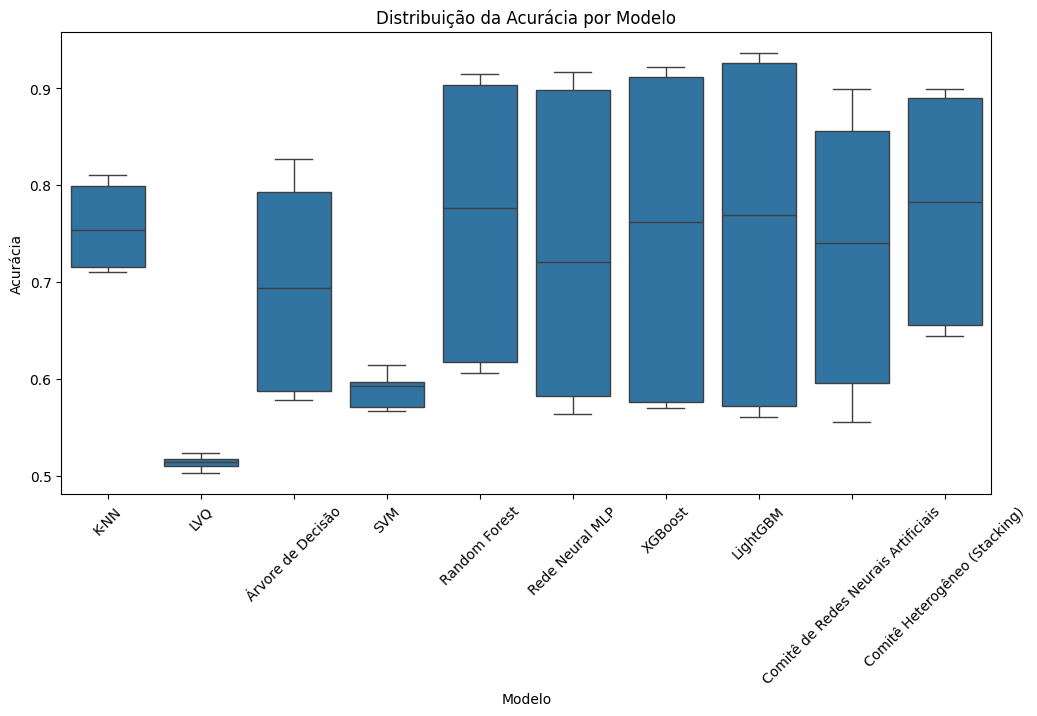

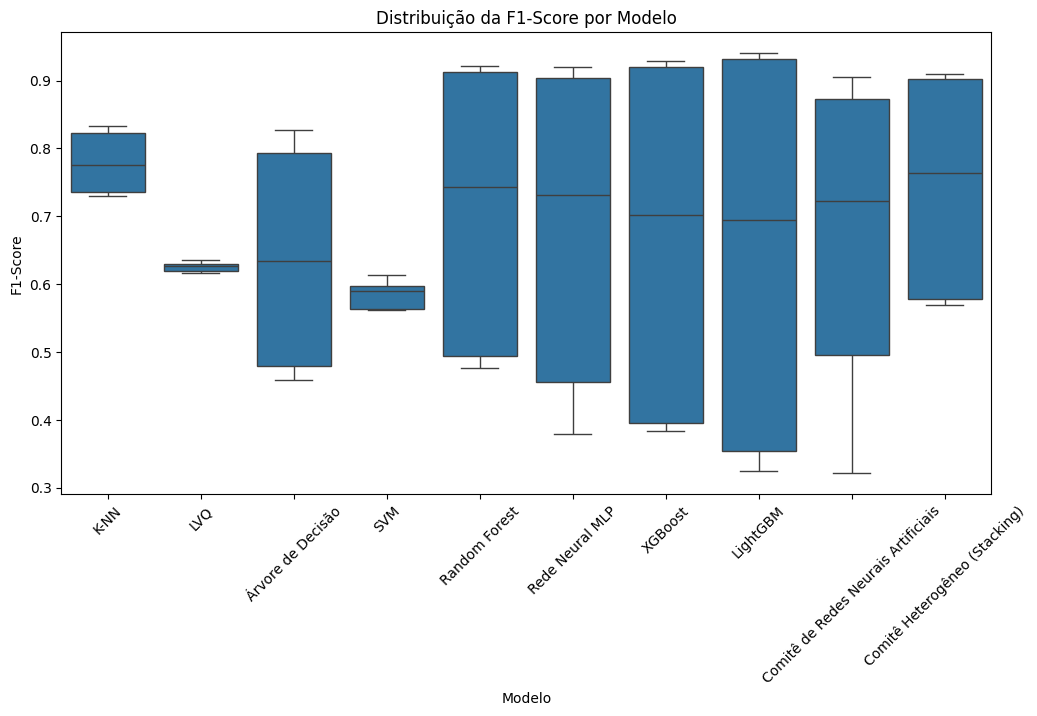

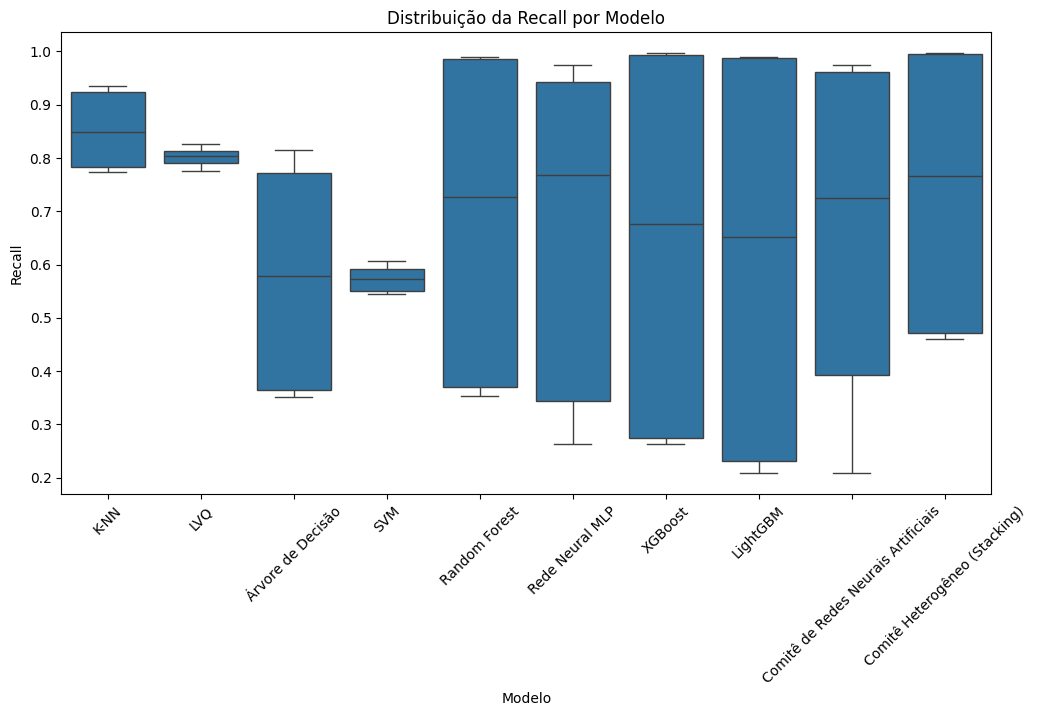

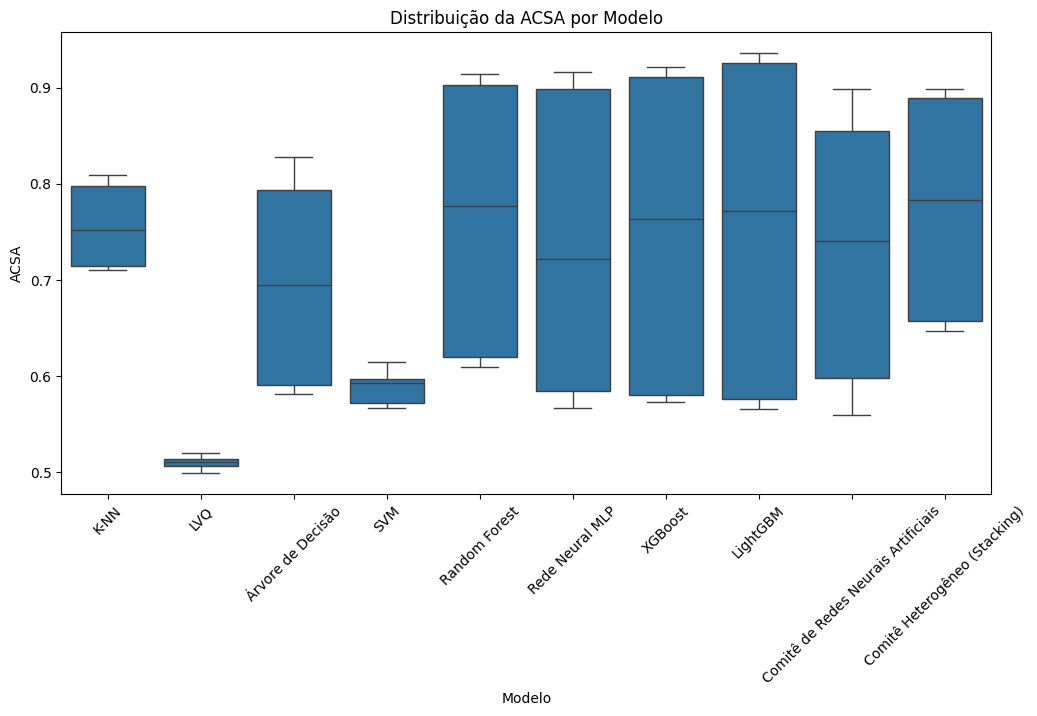

In [150]:
# Visualização das métricas com boxplots
for metrica in metricas:
    plt.figure(figsize=(12,6))
    sns.boxplot(x='Modelo', y=metrica, data=cv_results_df)
    plt.xticks(rotation=45)
    plt.title(f'Distribuição da {metrica} por Modelo')
    plt.show()

----

# Análise de Custo-Benefício

                                Modelo  Tempo de Treinamento (s)  \
0                                 K-NN                  3.801789   
1                                  LVQ                  1.745287   
2                    Árvore de Decisão                  1.248113   
3                                  SVM               1250.484934   
4                        Random Forest                  7.871273   
5                      Rede Neural MLP                 43.539377   
6                              XGBoost                  2.568904   
7                             LightGBM                  2.449782   
8  Comitê de Redes Neurais Artificiais                 89.335330   
9        Comitê Heterogêneo (Stacking)              10649.177576   

   Uso de Memória (bytes) Número de Parâmetros  
0                      48                  N/A  
1                      48                  N/A  
2                      48                  N/A  
3                      48                  N/A  
4     

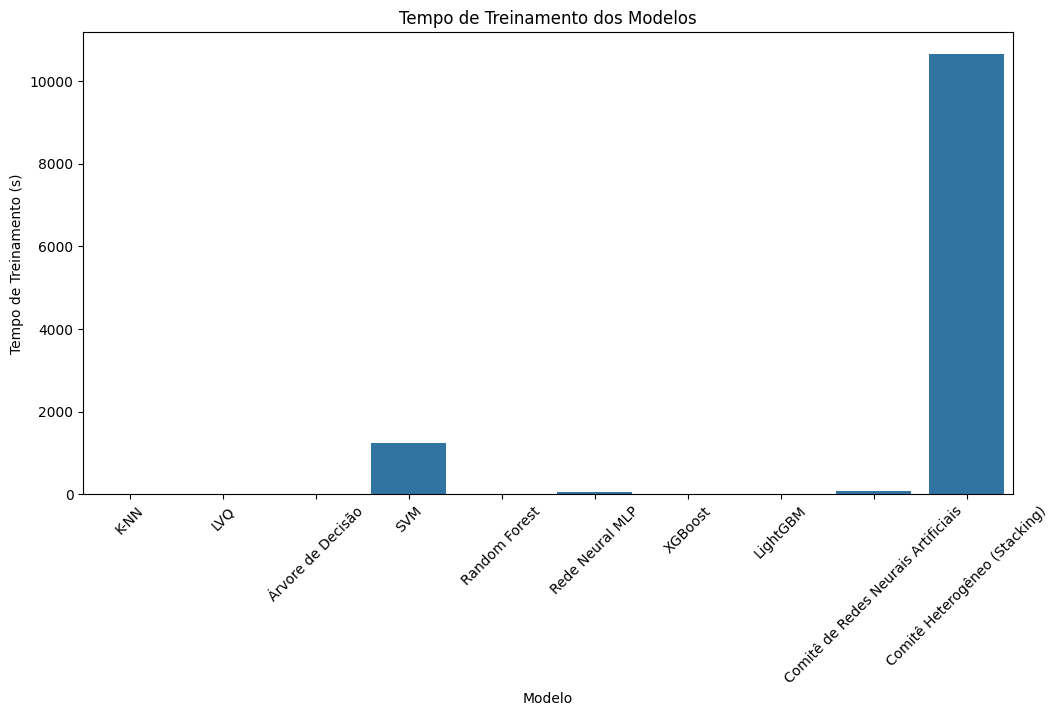

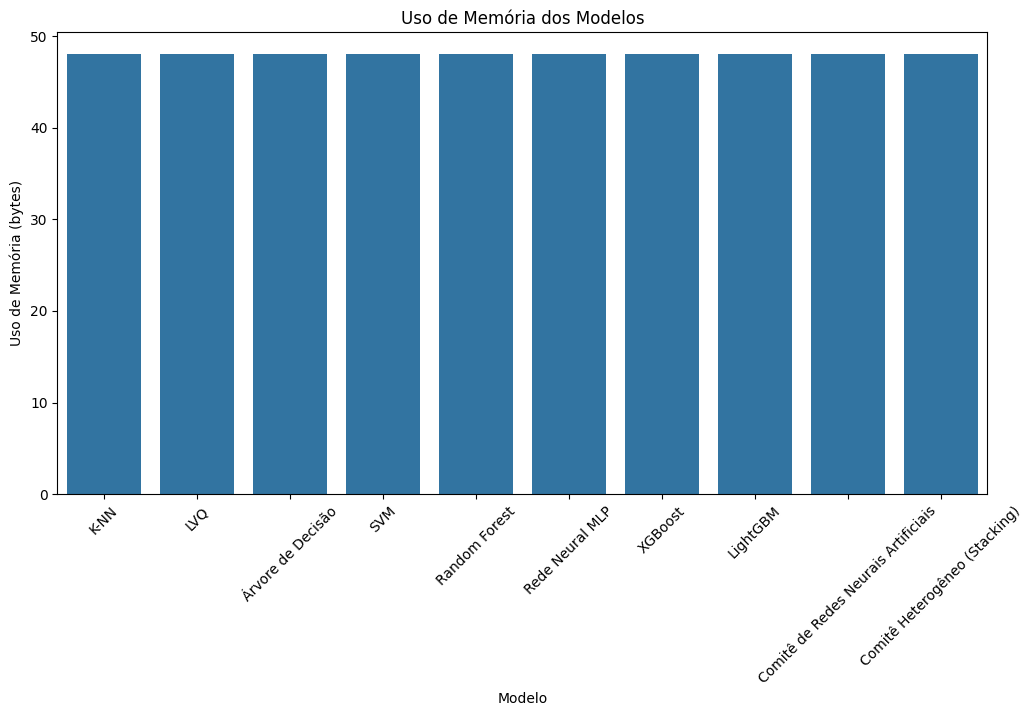

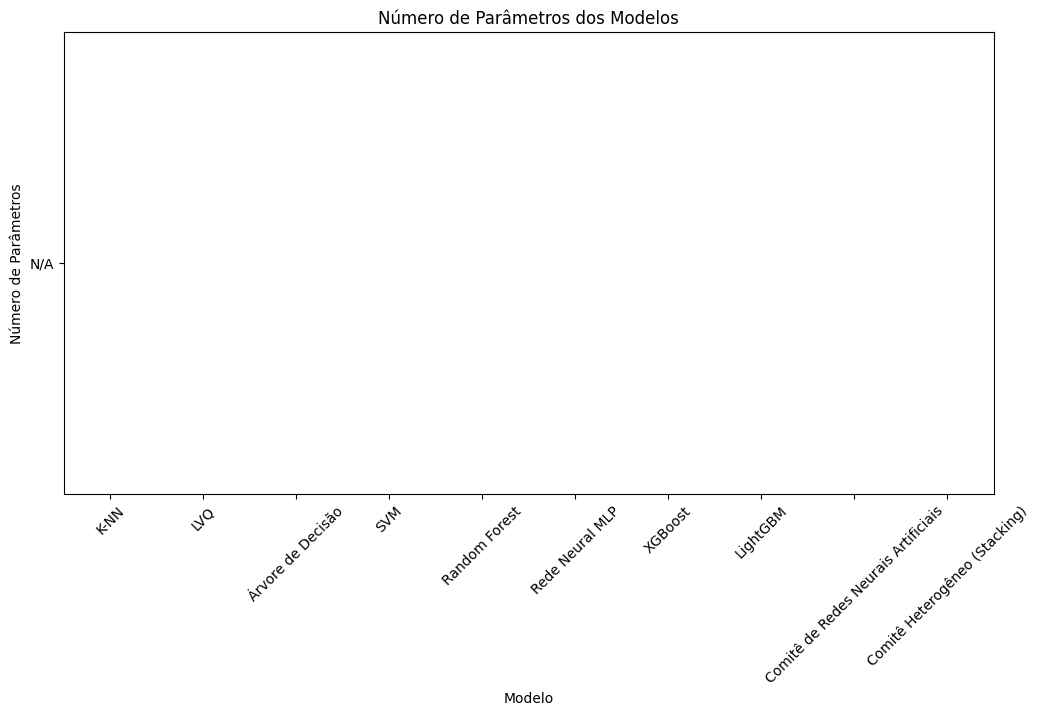

In [ ]:

# Convertendo para DataFrame
cost_benefit_df = pd.DataFrame(cost_benefit_results)

# Exibindo os resultados
print(cost_benefit_df)

# Plotando o tempo de treinamento
plt.figure(figsize=(12,6))
sns.barplot(x='Modelo', y='Tempo de Treinamento (s)', data=cost_benefit_df)
plt.xticks(rotation=45)
plt.title('Tempo de Treinamento dos Modelos')
plt.show()

# Plotando o uso de memória
plt.figure(figsize=(12,6))
sns.barplot(x='Modelo', y='Uso de Memória (bytes)', data=cost_benefit_df)
plt.xticks(rotation=45)
plt.title('Uso de Memória dos Modelos')
plt.show()

# Plotando o número de parâmetros
plt.figure(figsize=(12,6))
sns.barplot(x='Modelo', y='Número de Parâmetros', data=cost_benefit_df)
plt.xticks(rotation=45)
plt.title('Número de Parâmetros dos Modelos')
plt.show()


                                Modelo Número de Parâmetros  \
0                                 K-NN                  N/A   
1                                  LVQ                  N/A   
2                    Árvore de Decisão                  N/A   
3                                  SVM                  N/A   
4                        Random Forest                  N/A   
5                      Rede Neural MLP                  N/A   
6                              XGBoost                  N/A   
7                             LightGBM                  N/A   
8  Comitê de Redes Neurais Artificiais                  N/A   
9        Comitê Heterogêneo (Stacking)                  N/A   

   Tempo de Inferência (s)  
0                 0.762829  
1                 0.007098  
2                 0.005032  
3                31.181915  
4                 0.046421  
5                 0.019239  
6                 0.044110  
7                 0.012733  
8                 0.027477  
9               

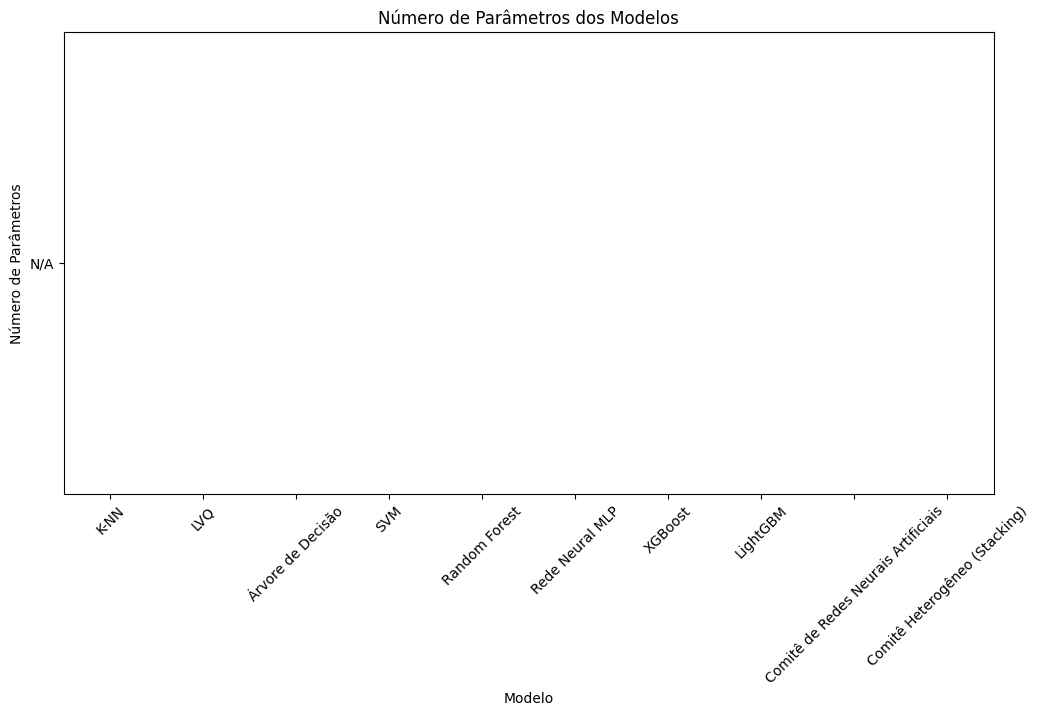

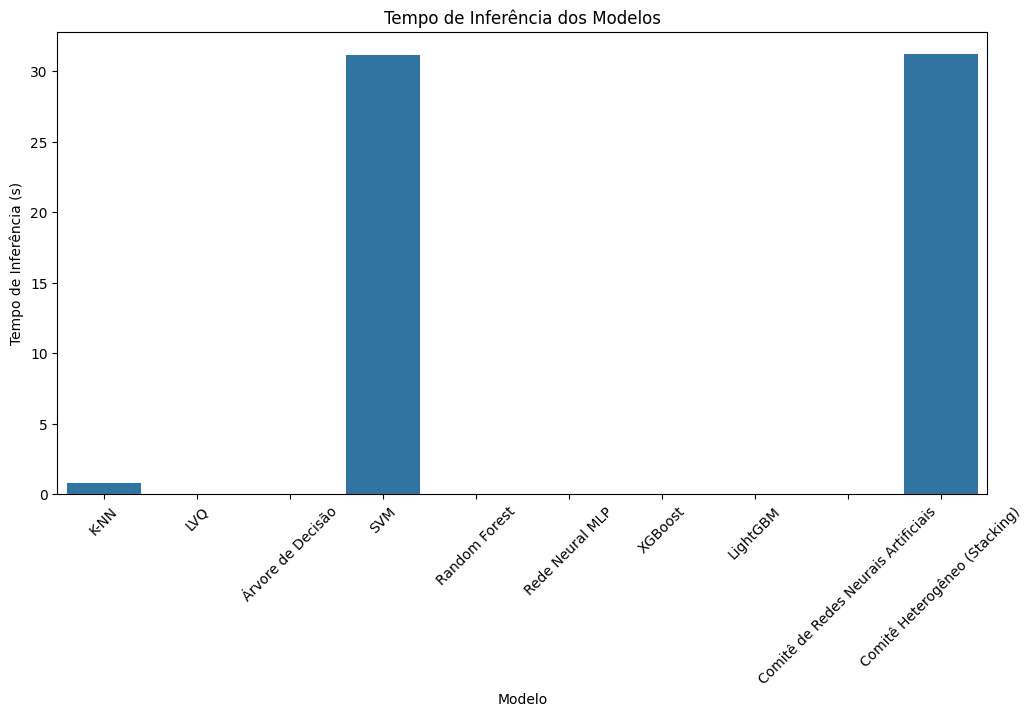

In [ ]:

# Convertendo para DataFrame
complexity_df = pd.DataFrame(complexity_results)

# Exibindo os resultados
print(complexity_df)

# Visualização das métricas de complexidade
plt.figure(figsize=(12,6))
sns.barplot(x='Modelo', y='Número de Parâmetros', data=complexity_df)
plt.xticks(rotation=45)
plt.title('Número de Parâmetros dos Modelos')
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(x='Modelo', y='Tempo de Inferência (s)', data=complexity_df)
plt.xticks(rotation=45)
plt.title('Tempo de Inferência dos Modelos')
plt.show()


In [167]:
complexity_df

,Modelo,Número de Parâmetros,Tempo de Inferência (s)
0,K-NN,N/A,0.762829
1,LVQ,N/A,0.007098
2,Árvore de Decisão,N/A,0.005032
3,SVM,N/A,31.181915
4,Random Forest,N/A,0.046421
5,Rede Neural MLP,N/A,0.019239
6,XGBoost,N/A,0.044110
7,LightGBM,N/A,0.012733
8,Comitê de Redes Neurais Artificiais,N/A,0.027477
9,Comitê Heterogêneo (Stacking),N/A,31.209070


----

# Teste de Estresse dos Modelos

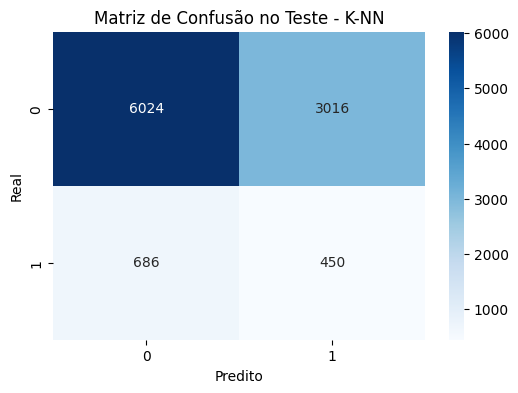

Relatório de Classificação no Teste para K-NN:
               precision    recall  f1-score   support

           0       0.90      0.67      0.76      9040
           1       0.13      0.40      0.20      1136

    accuracy                           0.64     10176
   macro avg       0.51      0.53      0.48     10176
weighted avg       0.81      0.64      0.70     10176



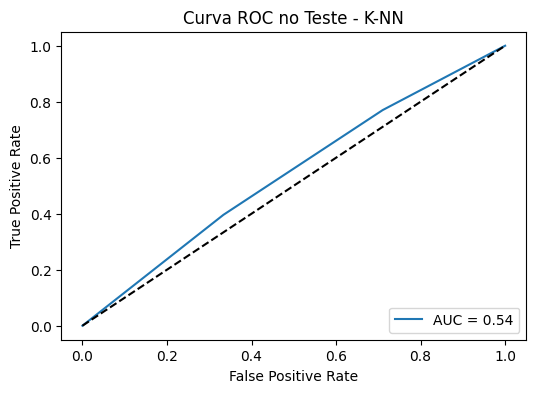

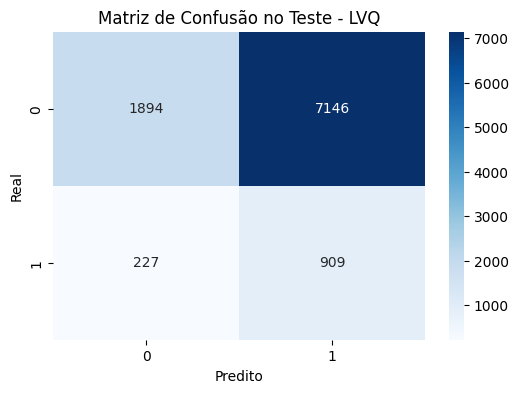

Relatório de Classificação no Teste para LVQ:
               precision    recall  f1-score   support

           0       0.89      0.21      0.34      9040
           1       0.11      0.80      0.20      1136

    accuracy                           0.28     10176
   macro avg       0.50      0.50      0.27     10176
weighted avg       0.81      0.28      0.32     10176

LVQ não suporta predict_proba, curva ROC não será plotada.


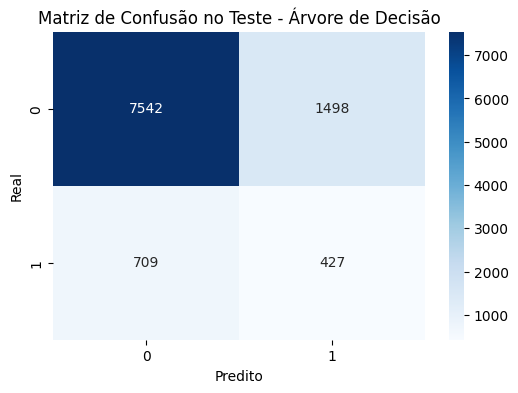

Relatório de Classificação no Teste para Árvore de Decisão:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87      9040
           1       0.22      0.38      0.28      1136

    accuracy                           0.78     10176
   macro avg       0.57      0.61      0.58     10176
weighted avg       0.84      0.78      0.81     10176



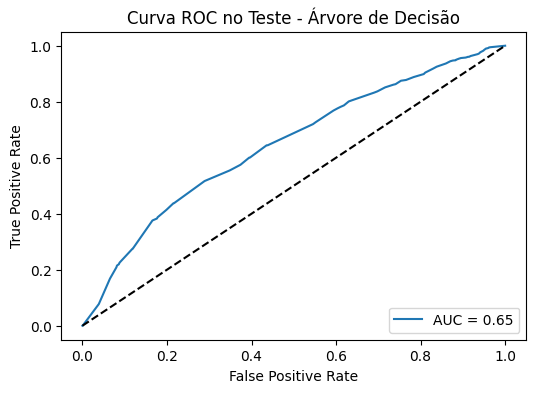

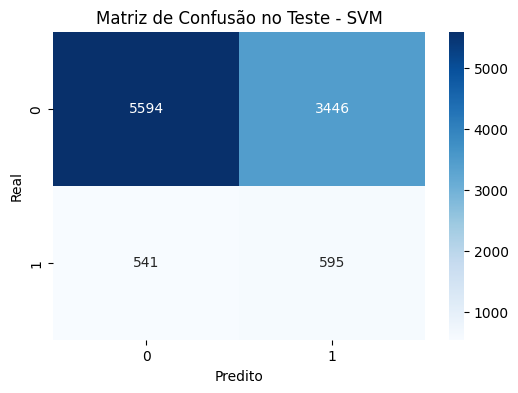

Relatório de Classificação no Teste para SVM:
               precision    recall  f1-score   support

           0       0.91      0.62      0.74      9040
           1       0.15      0.52      0.23      1136

    accuracy                           0.61     10176
   macro avg       0.53      0.57      0.48     10176
weighted avg       0.83      0.61      0.68     10176



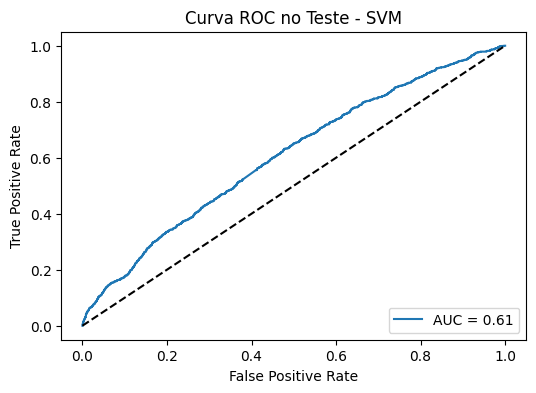

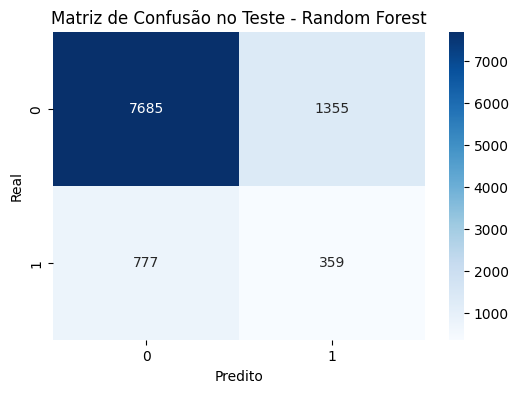

Relatório de Classificação no Teste para Random Forest:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88      9040
           1       0.21      0.32      0.25      1136

    accuracy                           0.79     10176
   macro avg       0.56      0.58      0.57     10176
weighted avg       0.83      0.79      0.81     10176



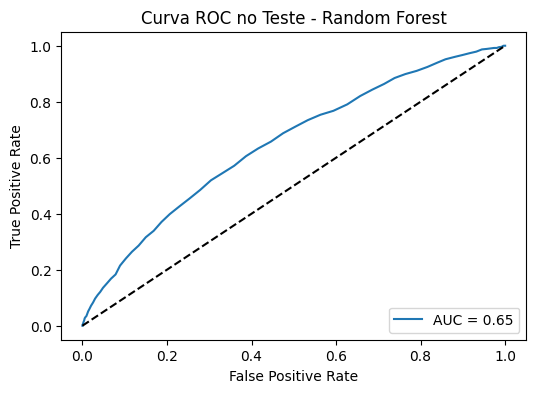

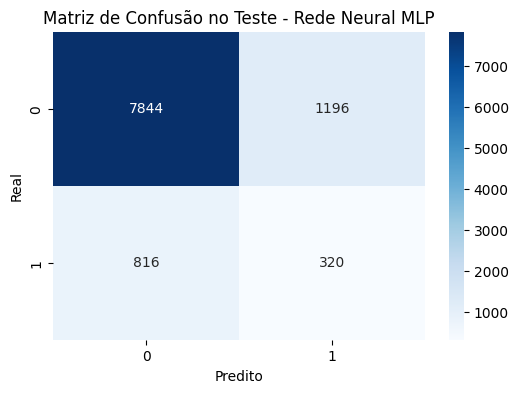

Relatório de Classificação no Teste para Rede Neural MLP:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      9040
           1       0.21      0.28      0.24      1136

    accuracy                           0.80     10176
   macro avg       0.56      0.57      0.56     10176
weighted avg       0.83      0.80      0.81     10176



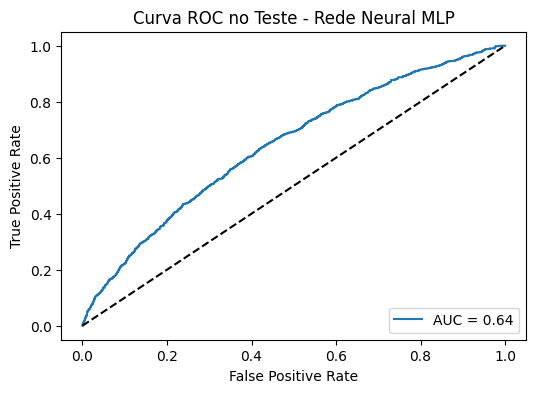

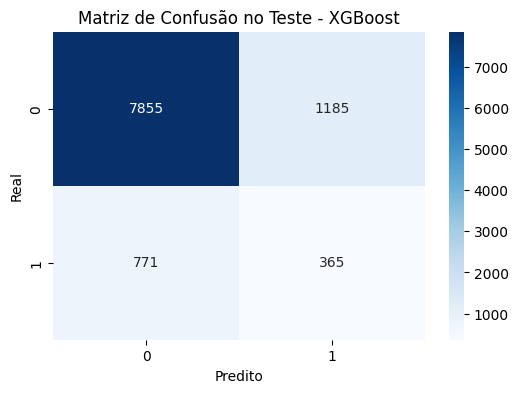

Relatório de Classificação no Teste para XGBoost:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      9040
           1       0.24      0.32      0.27      1136

    accuracy                           0.81     10176
   macro avg       0.57      0.60      0.58     10176
weighted avg       0.84      0.81      0.82     10176



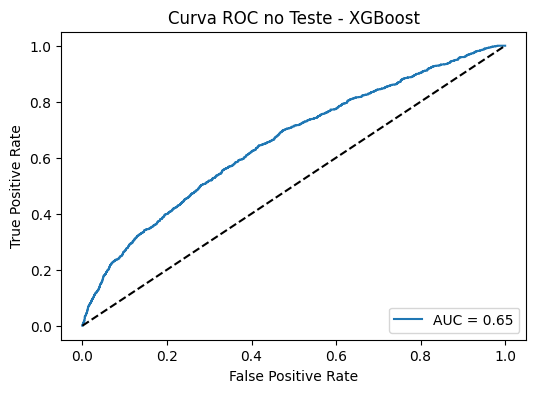

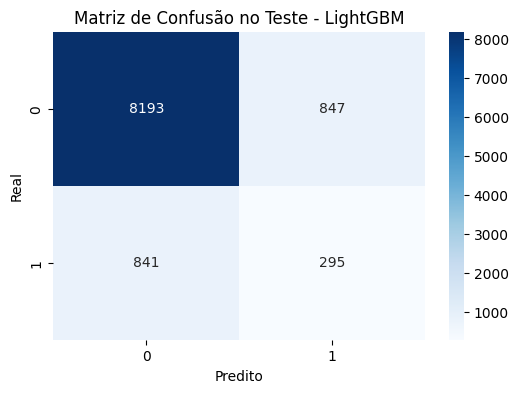

Relatório de Classificação no Teste para LightGBM:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      9040
           1       0.26      0.26      0.26      1136

    accuracy                           0.83     10176
   macro avg       0.58      0.58      0.58     10176
weighted avg       0.83      0.83      0.83     10176



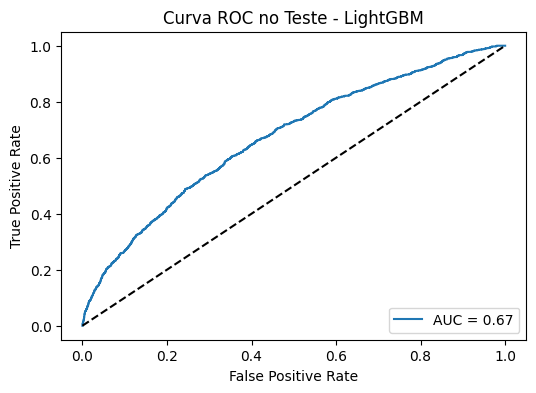

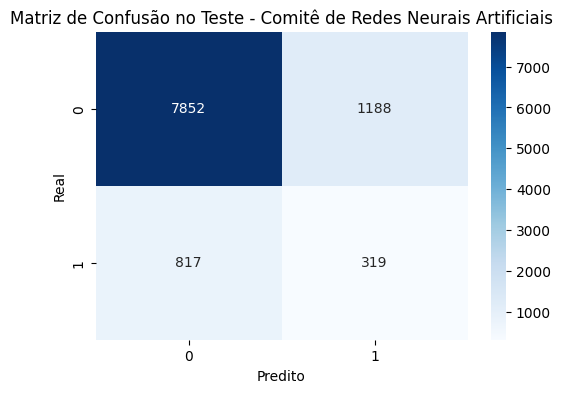

Relatório de Classificação no Teste para Comitê de Redes Neurais Artificiais:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      9040
           1       0.21      0.28      0.24      1136

    accuracy                           0.80     10176
   macro avg       0.56      0.57      0.56     10176
weighted avg       0.83      0.80      0.81     10176



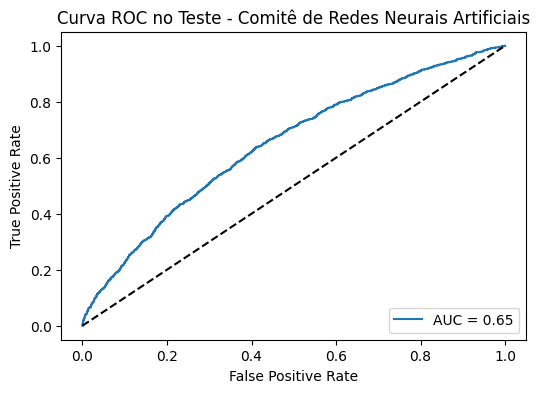

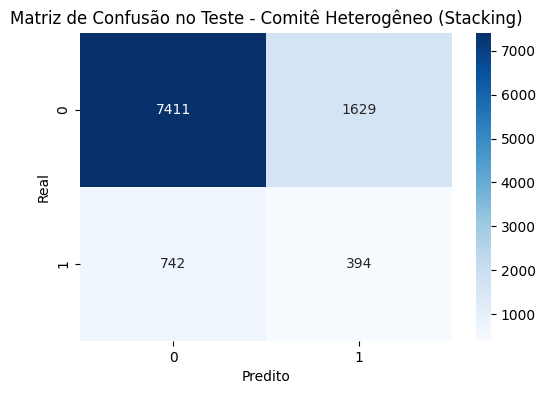

Relatório de Classificação no Teste para Comitê Heterogêneo (Stacking):
               precision    recall  f1-score   support

           0       0.91      0.82      0.86      9040
           1       0.19      0.35      0.25      1136

    accuracy                           0.77     10176
   macro avg       0.55      0.58      0.56     10176
weighted avg       0.83      0.77      0.79     10176



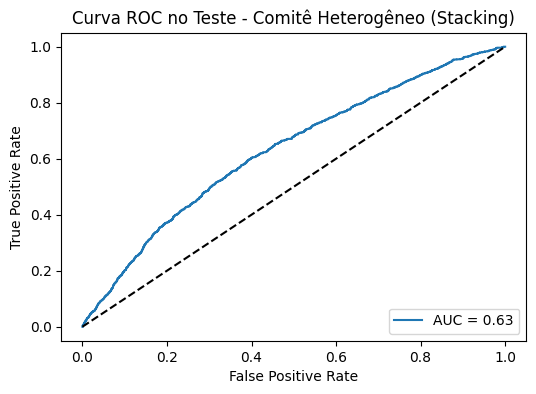

In [ ]:
stress_test_results = []

for model_name, model in models.items():
    # Verificando se já temos o modelo treinado e as previsões armazenadas
    # Fazendo previsão no conjunto de teste
    start_inference = time.time()
    y_pred_test = model.predict(X_test)
    end_inference = time.time()
    test_inference_time = end_inference - start_inference
    
    # Armazenando o tempo de inferência no teste
    inference_times[model_name] += test_inference_time  # Somando ao tempo de inferência total
    
    # Calculando as métricas no conjunto de teste
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    cm = confusion_matrix(y_test, y_pred_test)
    acsa_test = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    
    stress_test_results.append({
        'Modelo': model_name,
        'Acurácia': acc_test,
        'F1-Score': f1_test,
        'Recall': recall_test,
        'ACSA': acsa_test
    })
    
    # Armazenando as previsões para uso posterior
    model_predictions[model_name]['test'] = y_pred_test
    
    # Plotando a matriz de confusão
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão no Teste - {model_name}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()
    
    # Imprimindo o relatório de classificação
    print(f"Relatório de Classificação no Teste para {model_name}:\n", classification_report(y_test, y_pred_test))
    
    # Plotando a curva ROC, se possível
    if hasattr(model, "predict_proba"):
        y_prob_test = model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
        roc_auc = roc_auc_score(y_test, y_prob_test)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0,1], [0,1], 'k--')
        plt.title(f'Curva ROC no Teste - {model_name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print(f"{model_name} não suporta predict_proba, curva ROC não será plotada.")



                                Modelo  Acurácia  F1-Score    Recall      ACSA
0                                 K-NN  0.636203  0.195567  0.396127  0.531249
1                                  LVQ  0.275452  0.197802  0.800176  0.504845
2                    Árvore de Decisão  0.783117  0.278994  0.375880  0.605086
3                                  SVM  0.608196  0.229863  0.523768  0.571286
4                        Random Forest  0.790487  0.251930  0.316021  0.583066
5                      Rede Neural MLP  0.802280  0.241327  0.281690  0.574695
6                              XGBoost  0.807783  0.271780  0.321303  0.595109
7                             LightGBM  0.834119  0.258999  0.259683  0.582994
8  Comitê de Redes Neurais Artificiais  0.802968  0.241392  0.280810  0.574697
9        Comitê Heterogêneo (Stacking)  0.767001  0.249446  0.346831  0.583316


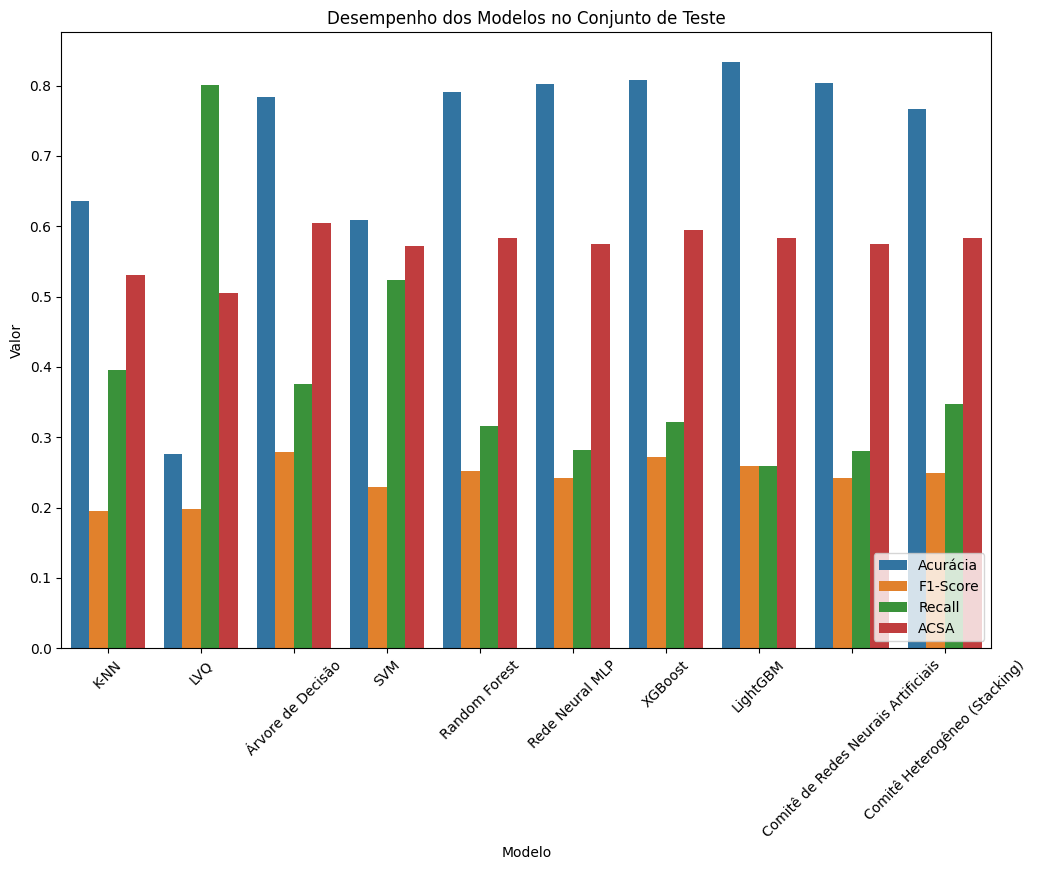

In [157]:
# Convertendo para DataFrame
stress_test_df = pd.DataFrame(stress_test_results)

# Exibindo os resultados
print(stress_test_df)

# Plotando as métricas no conjunto de teste
stress_test_melted = stress_test_df.melt(id_vars='Modelo', value_vars=['Acurácia', 'F1-Score', 'Recall', 'ACSA'], var_name='Métrica', value_name='Valor')

plt.figure(figsize=(12,8))
sns.barplot(x='Modelo', y='Valor', hue='Métrica', data=stress_test_melted)
plt.xticks(rotation=45)
plt.title('Desempenho dos Modelos no Conjunto de Teste')
plt.legend(loc='lower right')
plt.show()


                                Modelo  Acurácia  F1-Score    Recall  \
0                                 K-NN  0.642140  0.209818  0.425551   
1                                  LVQ  0.275920  0.196660  0.793833   
2                    Árvore de Decisão  0.776805  0.254844  0.341850   
3                                  SVM  0.605351  0.229647  0.526872   
4                        Random Forest  0.783494  0.231226  0.291630   
5                      Rede Neural MLP  0.799626  0.216237  0.247577   
6                              XGBoost  0.796478  0.231712  0.274890   
7                             LightGBM  0.826284  0.243359  0.250220   
8  Comitê de Redes Neurais Artificiais  0.804643  0.233205  0.266079   
9        Comitê Heterogêneo (Stacking)  0.762640  0.233238  0.323348   

       ACSA  Tempo de Treinamento (s)  Uso de Memória (bytes)  
0  0.547456                  3.801789                      48  
1  0.502331                  1.745287                      48  
2  0.586660    

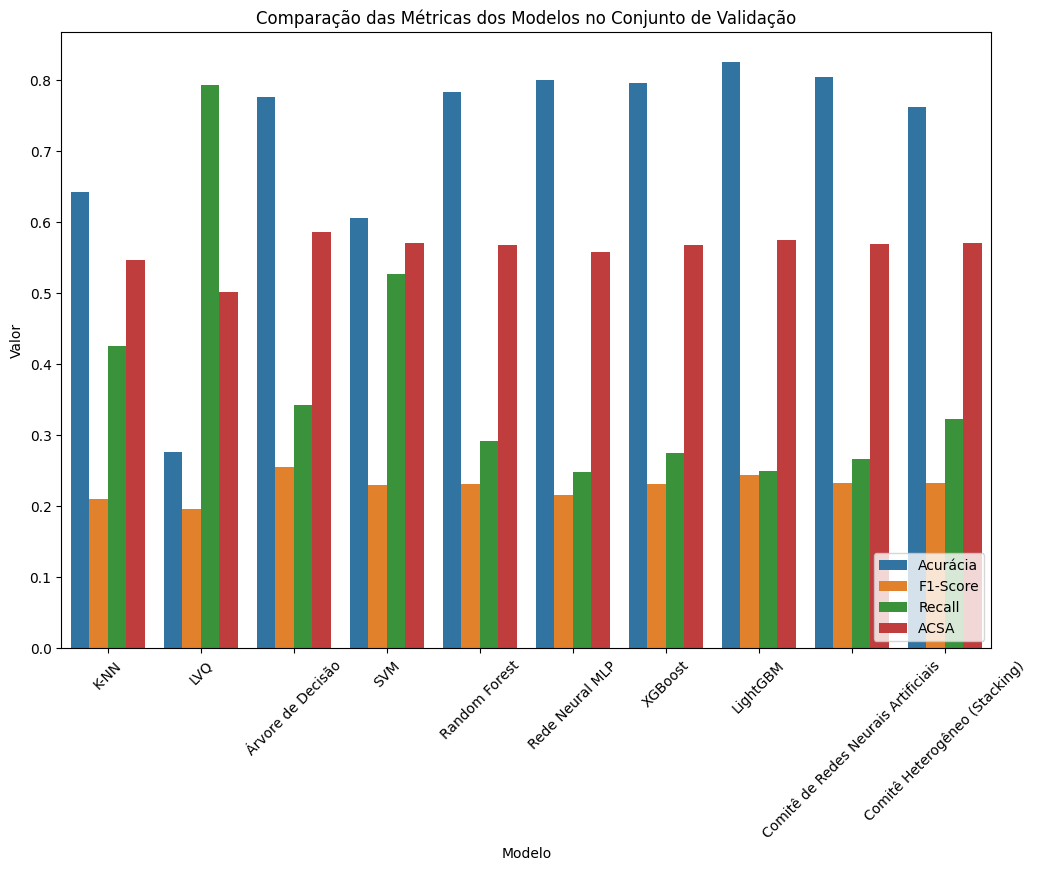

In [158]:
# Convertendo para DataFrame
final_results_df = pd.DataFrame(final_results)

# Exibindo os resultados finais
print(final_results_df)

# Plotando as métricas
final_results_melted = final_results_df.melt(id_vars='Modelo', value_vars=['Acurácia', 'F1-Score', 'Recall', 'ACSA'], var_name='Métrica', value_name='Valor')

plt.figure(figsize=(12,8))
sns.barplot(x='Modelo', y='Valor', hue='Métrica', data=final_results_melted)
plt.xticks(rotation=45)
plt.title('Comparação das Métricas dos Modelos no Conjunto de Validação')
plt.legend(loc='lower right')
plt.show()


----

# Discussão sobre Limitações e Futuras Melhorias

Durante o projeto, enfrentamos algumas limitações significativas que impactaram os resultados obtidos. O tamanho e a diversidade limitados do conjunto de dados restringiram a capacidade dos modelos de capturar todas as nuances presentes nos dados de pacientes diabéticos. Além disso, a falta de tempo disponível para o projeto afetou o ajuste fino dos modelos, impedindo uma otimização mais aprofundada dos hiperparâmetros. Os recursos computacionais escassos também prejudicaram o processo de otimização, especialmente para modelos mais complexos que demandam maior poder de processamento.

Essas limitações tiveram impactos diretos nos resultados. Devido ao uso parcial dos dados de treinamento, a performance dos modelos mais complexos ficou comprometida, não alcançando todo o seu potencial preditivo. As curvas ROC geradas indicaram uma baixa distinção entre as classes, sugerindo que os modelos não foram capazes de separar efetivamente os pacientes com maior risco de readmissão daqueles com menor risco. As matrizes de confusão mostraram uma quantidade significativa de previsões incorretas, evidenciando dificuldades na generalização dos modelos para dados novos.

Para superar essas limitações e aprimorar os resultados futuros, propomos algumas melhorias. A ampliação do conjunto de dados de treinamento é fundamental para fornecer aos modelos mais informações e possibilitar a captura de padrões mais complexos. Aumentar o número de iterações no processo de otimização permitirá um ajuste mais refinado dos hiperparâmetros, melhorando o desempenho dos modelos. Além disso, compreender melhor as decisões de treinamento dos modelos através de ferramentas como LIME (Local Interpretable Model-Agnostic Explanations) ou SHAP (SHapley Additive exPlanations) pode oferecer insights valiosos sobre o funcionamento interno dos algoritmos, possibilitando ajustes mais precisos. Por fim, consideramos a modificação do modelo LVQ para a variante Generalized Learning Vector Quantization, disponível na biblioteca sklearn-lvq, que pode oferecer melhorias significativas em termos de precisão e capacidade de generalização.

----

# Resumo Executivo

Este estudo teve como objetivo desenvolver modelos preditivos para identificar pacientes diabéticos com maior risco de readmissão hospitalar. Utilizamos diversos algoritmos de aprendizado de máquina, incluindo K-NN, Árvore de Decisão, SVM, Random Forest, Redes Neurais e modelos avançados como XGBoost e LightGBM. Apesar dos desafios enfrentados, como limitações no conjunto de dados e recursos computacionais restritos, conseguimos identificar que modelos como o LightGBM e o XGBoost apresentaram os melhores desempenhos em termos de acurácia e capacidade de generalização.

No entanto, observamos que a distinção entre pacientes de alto e baixo risco ainda é um desafio, indicando a necessidade de dados mais abrangentes e técnicas de modelagem mais avançadas. Recomendamos a ampliação do conjunto de dados e o uso de ferramentas interpretativas para melhor compreensão dos modelos. Esses passos são essenciais para desenvolver um sistema preditivo robusto que possa auxiliar profissionais de saúde na tomada de decisões e, consequentemente, melhorar o cuidado com pacientes diabéticos.

----

# Comparação com Benchmarks conhecidos

Para contextualizar nossos resultados, realizamos uma comparação com estudos anteriores que utilizaram conjunto de dados ou abordagens semelhantes. O estudo pioneiro "Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records" de Beata Strack et al. (2014) utilizou o dataset "130-US diabetes" para analisar a influência da medida de HbA1c nas taxas de readmissão hospitalar. Nesse trabalho, os autores aplicaram técnicas de mineração de dados para identificar padrões que poderiam prever a readmissão de pacientes.

Enquanto o estudo de Strack et al. focou na análise estatística e identificação de fatores de risco, nosso projeto buscou desenvolver modelos preditivos específicos para a classificação de pacientes. Embora não seja possível fazer uma comparação direta devido às diferenças metodológicas, ambos os estudos ressaltam a complexidade envolvida na previsão de readmissões hospitalares em pacientes diabéticos.

Outros estudos, como o de Abegaz et al. (2023), "Application of Machine Learning Algorithms to Predict Uncontrolled Diabetes Using the All of Us Research Program Data", utilizaram modelos como random forest, extreme gradient boost e regressão logística para classificar dados de diabetes, obtendo acurácias em torno de 64% a 80%. Nossos resultados são consistentes com esses achados, especialmente considerando que modelos como LightGBM e XGBoost alcançaram acurácias superiores a 80%.

Outro estudo, realizado por Alanazi & Mazher (2020), "Using Machine Learning Algorithms For Prediction Of Diabetes Mellitus", utilizou dois algoritmos combinados de machine learning, Support Vector Machine e Random Forest para predição de diabetes, utilizando dados reais coletados da Security Force Primary Health Care. O modelo proposto atingiu 98% de precisão, e ROC 99%. 

As diferenças observadas podem ser atribuídas às variações nos conjuntos de dados, técnicas de pré-processamento e recursos computacionais disponíveis. Enquanto alguns estudos tiveram acesso a conjuntos de dados mais extensos e diversos, nosso projeto foi limitado pelo tamanho e diversidade dos dados, afetando o desempenho dos modelos.

----

# Desenvolvimento detalhado do projeto

Inicialmente, fizemos um entendimento do negócio a fim de obter mais informações sobre os dados e seus objetivos. Em seguida, realizamos uma análise exploratória dos dados com o intuito de verificar a distribuição e os padrões do conjunto de dados. Após, dividimos e carregamos os conjuntos de dados de treinamento, validação e teste, separando as features e a variável alvo. Identificamos um desbalanceamento significativo nas classes, com a maioria das amostras pertencendo à classe majoritária. Para mitigar esse problema, aplicamos técnicas de balanceamento, como o Random Under Sampling para reduzir a classe majoritária e o ADASYN para aumentar a classe minoritária de forma sintética.

Em seguida, definimos uma variedade de modelos para avaliação, abrangendo desde algoritmos tradicionais até modelos avançados e comitês. Para dois dos modelos, K-NN e Árvore de Decisão, realizamos a otimização de hiperparâmetros utilizando o Optuna, explorando diferentes configurações para maximizar o desempenho. Os melhores hiperparâmetros encontrados foram:

K-NN: n_neighbors=2, weights='uniform', algorithm='auto'.
Árvore de Decisão: max_depth=8, min_samples_split=9, criterion='entropy'.
Os modelos foram avaliados utilizando validação cruzada estratificada com 10 folds, garantindo uma avaliação consistente e reduzindo a variabilidade nos resultados. Coletamos métricas como Acurácia, F1-Score, Recall e ACSA para cada modelo.

Os resultados indicaram que modelos como LightGBM e XGBoost apresentaram desempenho superior, com acurácias acima de 80%. No entanto, observamos que o desempenho em termos de recall para a classe minoritária foi geralmente baixo, sugerindo dificuldades na correta classificação de pacientes com maior risco de readmissão. O modelo LVQ apresentou uma acurácia significativamente inferior, evidenciando limitações em sua capacidade preditiva no contexto dos dados utilizados.

Realizamos análises estatísticas para verificar a significância das diferenças observadas entre os modelos. O teste de Friedman indicou diferenças significativas em métricas como Acurácia e ACSA. Aplicamos o teste de Conover para identificar quais modelos apresentavam diferenças significativas entre si, confirmando que alguns modelos superaram outros de forma estatisticamente relevante.

Ao analisar o custo-benefício, consideramos o tempo de treinamento e inferência de cada modelo. Modelos como o SVM e o Comitê Heterogêneo (Stacking) apresentaram tempos de processamento elevados, o que pode limitar sua aplicação prática em ambientes com recursos computacionais restritos. Em contrapartida, modelos como LightGBM e XGBoost proporcionaram um bom equilíbrio entre desempenho e eficiência computacional.

Durante o teste de estresse com dados desconhecidos, observamos que os modelos mantiveram um desempenho consistente com os resultados obtidos na validação cruzada. No entanto, a precisão na classificação da classe minoritária permaneceu um desafio, indicando que os modelos não generalizaram plenamente para novos dados.

As limitações encontradas no projeto tiveram um impacto considerável nos resultados obtidos. O tamanho e a diversidade limitados do conjunto de dados restringiram a capacidade dos modelos de aprender padrões complexos e generalizar para novos dados. A falta de tempo impediu um ajuste fino mais aprofundado dos modelos, o que poderia ter melhorado o desempenho, especialmente dos modelos mais complexos. Além disso, os recursos computacionais limitados dificultaram a otimização de hiperparâmetros, principalmente para modelos como o SVM e os comitês, que requerem maior poder de processamento.

Essas limitações resultaram em impactos como o uso parcial dos dados de treinamento, comprometendo a performance dos modelos mais complexos. As curvas ROC indicaram uma baixa distinção entre as classes, e as matrizes de confusão revelaram um número significativo de previsões incorretas, especialmente para a classe minoritária.

Para mitigar essas limitações, futuras melhorias devem incluir a ampliação do conjunto de dados de treinamento, buscando incorporar dados de diferentes fontes e aumentar a diversidade das amostras. Aumentar o número de iterações no processo de otimização permitirá um ajuste mais refinado dos hiperparâmetros, potencializando o desempenho dos modelos. A utilização de ferramentas interpretativas como LIME ou SHAP pode proporcionar insights sobre as decisões dos modelos, identificando possíveis vieses e áreas de melhoria. Por fim, a adaptação do modelo LVQ para sua versão generalizada, disponível na biblioteca sklearn-lvq, pode oferecer avanços significativos em termos de precisão e capacidade de generalização.

----

# Conclusão

O projeto proporcionou uma visão abrangente sobre a aplicação de diferentes modelos de aprendizado de máquina na classificação de dados de pacientes diabéticos. Apesar das limitações encontradas, conseguimos identificar modelos com desempenho promissor, como o LightGBM e o XGBoost. No entanto, os desafios na classificação da classe minoritária destacam a necessidade de melhorias no conjunto de dados e nas técnicas de modelagem utilizadas. Investimentos futuros em dados mais robustos, recursos computacionais adequados e técnicas avançadas de interpretação de modelos serão essenciais para aprimorar a precisão e a confiabilidade das previsões, contribuindo para melhorias significativas no cuidado de pacientes diabéticos.

----

# Referências

Strack, B., DeShazo, J. P., Gennings, C., Olmo, J. L., Ventura, S., Cios, K. J., & Clore, J. N. (2014). Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records. BioMed Research International, 2014.

Abegaz TM, Ahmed M, Sherbeny F, Diaby V, Chi H, Ali AA. Application of Machine Learning Algorithms to Predict Uncontrolled Diabetes Using the All of Us Research Program Data. Healthcare (Basel). 2023 Apr 15;11(8):1138. doi: 10.3390/healthcare11081138. PMID: 37107973; PMCID: PMC10137945.

A. S. Alanazi and M. A. Mezher, "Using Machine Learning Algorithms For Prediction Of Diabetes Mellitus," 2020 International Conference on Computing and Information Technology (ICCIT-1441), Tabuk, Saudi Arabia, 2020, pp. 1-3, doi: 10.1109/ICCIT-144147971.2020.9213708.

Ravi, Daniele et al. “Deep Learning for Health Informatics.” IEEE journal of biomedical and health informatics vol. 21,1 (2017): 4-21. doi:10.1109/JBHI.2016.2636665

Kanita Karaduzovic-Hadziabdica and Raşit Kökerb. Diagnosis of heart disease using a committee machine neural network. In Proceedings of the 9th International Conference on Applied Informatics, volume 1, pages 351–360, 2015.

Guolin Ke, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, and Tie-Yan Liu. Lightgbm: A highly efficient gradient boosting decision tree. In Proceedings of the 31st Conference on Neural Information Processing Systems (NeurIPS), pages 3146–3154, 2017. URL https://proceedings.neurips.cc/paper_files/paper/2017/file/f2b30b1f9d4e8c3e3f4a5ffb1b094d8b-Paper.pdf.

C.J. Merz. Using correspondence analysis to combine classifiers. Machine Learning, 36:33–58, 1999. doi: 10.1023/A:1007559205422. URL https://doi.org/10.1023/A:1007559205422.

Alexander Seewald. Towards a theoretical framework for ensemble classification. pages 1443–1444, 01 2003.

Corey Wade. Hands-On Gradient Boosting with XGBoost and scikit-learn: Perform accessible machine learning and extreme gradient boosting with Python. Packt Publishing, Birmingham, UK, 2020. ISBN 978-1839218354.